# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

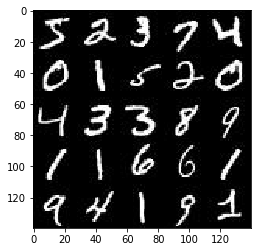

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

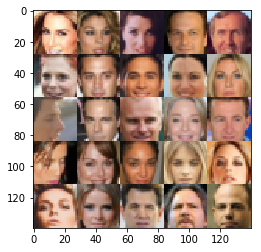

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_image_input = tf.placeholder(tf.float32,
                                      (None, image_width, image_height , image_channels),
                                      name='real_input')
    z_data_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_image_input, z_data_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28 (dim)
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(conv1, alpha*conv1)
        # 14x14 (dim)
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(bn2, alpha*bn2)

        # 7x7 (dim)
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(bn3, alpha*bn3)

        # logits
        logits = tf.nn.dropout(tf.layers.dense(tf.reshape(relu3, (-1, 4*4*256)), 1), keep_prob=0.9)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        # fully connected first layer
        fc = tf.reshape(tf.layers.dense(z, 7*7*256), (-1, 7, 7, 256))
        bn1 =  tf.layers.batch_normalization(fc, training=is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        # 7x7x256
    
        # first transpose conv
        conv1 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 =  tf.layers.batch_normalization(conv1, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # 14x14x128

#         conv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same')
#         bn3 =  tf.layers.batch_normalization(conv3, training=is_train)
#         relu3 = tf.maximum(alpha*bn3, bn3)
#         # 14x14x128

        
        
        # second transpose conv
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
    
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real,
        labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                    labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                    labels=tf.ones_like(d_model_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,
                                                                                  var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,
                                                                                  var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Building Model
    print("batch size: {}".format(batch_size))
    real_image_input, z_data_input, learning_rate_t = model_inputs(data_shape[1], data_shape[2]
                                                                 , data_shape[3],  z_dim)
    d_loss, g_loss = model_loss(input_real=real_image_input, input_z=z_data_input,
                                out_channel_dim=data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_t, beta1)
    
    steps = 0
    print_every = 5
    show_every = 60
    to_show_images = 25

    # losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_ = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_ += 1
                # scale from [-.5, +.5] to [-1, 1]
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                _ = sess.run(d_opt, feed_dict={real_image_input:batch_images,
                                               z_data_input: batch_z,
                                               learning_rate_t: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_image_input:batch_images,
                                               z_data_input: batch_z,
                                              learning_rate_t: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_image_input:batch_images,
                                                   z_data_input: batch_z})
                    train_loss_g = g_loss.eval({z_data_input: batch_z})

                    print("Epoch {}/{}... batch: {}".format(epoch_i+1, epoch_count, batch_),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, to_show_images, z_data_input, data_shape[3], data_image_mode)

        # final model state (visualization)
        show_generator_output(sess, to_show_images, z_data_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
batch size: 32
Epoch 1/2... batch: 5 Discriminator Loss: 1.5302... Generator Loss: 0.8116
Epoch 1/2... batch: 10 Discriminator Loss: 0.9015... Generator Loss: 1.3468
Epoch 1/2... batch: 15 Discriminator Loss: 0.9698... Generator Loss: 1.8637
Epoch 1/2... batch: 20 Discriminator Loss: 1.2134... Generator Loss: 4.3695
Epoch 1/2... batch: 25 Discriminator Loss: 3.4445... Generator Loss: 0.2862
Epoch 1/2... batch: 30 Discriminator Loss: 2.2540... Generator Loss: 0.4031
Epoch 1/2... batch: 35 Discriminator Loss: 1.1904... Generator Loss: 0.8401
Epoch 1/2... batch: 40 Discriminator Loss: 1.3041... Generator Loss: 2.5313
Epoch 1/2... batch: 45 Discriminator Loss: 1.1174... Generator Loss: 1.6442
Epoch 1/2... batch: 50 Discriminator Loss: 1.5119... Generator Loss: 0.7143
Epoch 1/2... batch: 55 Discriminator Loss: 2.7206... Generator Loss: 5.0720
Epoch 1/2... batch: 60 Discriminator Loss: 1.2412... Generator Loss: 2.2933


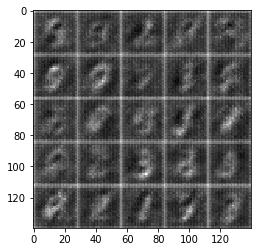

Epoch 1/2... batch: 65 Discriminator Loss: 1.1197... Generator Loss: 2.2999
Epoch 1/2... batch: 70 Discriminator Loss: 1.2472... Generator Loss: 0.7406
Epoch 1/2... batch: 75 Discriminator Loss: 1.0215... Generator Loss: 1.4543
Epoch 1/2... batch: 80 Discriminator Loss: 1.5334... Generator Loss: 0.4842
Epoch 1/2... batch: 85 Discriminator Loss: 1.0493... Generator Loss: 2.3983
Epoch 1/2... batch: 90 Discriminator Loss: 1.2703... Generator Loss: 1.4558
Epoch 1/2... batch: 95 Discriminator Loss: 1.0258... Generator Loss: 1.7004
Epoch 1/2... batch: 100 Discriminator Loss: 1.3713... Generator Loss: 0.6036
Epoch 1/2... batch: 105 Discriminator Loss: 0.9664... Generator Loss: 2.1273
Epoch 1/2... batch: 110 Discriminator Loss: 1.1950... Generator Loss: 0.7400
Epoch 1/2... batch: 115 Discriminator Loss: 1.5395... Generator Loss: 0.5420
Epoch 1/2... batch: 120 Discriminator Loss: 1.1050... Generator Loss: 1.0537


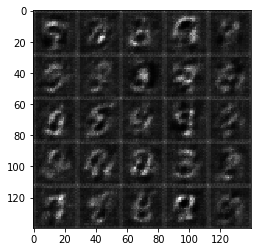

Epoch 1/2... batch: 125 Discriminator Loss: 0.9599... Generator Loss: 1.1629
Epoch 1/2... batch: 130 Discriminator Loss: 1.1007... Generator Loss: 0.9172
Epoch 1/2... batch: 135 Discriminator Loss: 1.7256... Generator Loss: 0.4099
Epoch 1/2... batch: 140 Discriminator Loss: 1.3996... Generator Loss: 0.5410
Epoch 1/2... batch: 145 Discriminator Loss: 1.1039... Generator Loss: 0.7911
Epoch 1/2... batch: 150 Discriminator Loss: 0.9700... Generator Loss: 1.1904
Epoch 1/2... batch: 155 Discriminator Loss: 1.0498... Generator Loss: 1.1022
Epoch 1/2... batch: 160 Discriminator Loss: 0.9683... Generator Loss: 1.6294
Epoch 1/2... batch: 165 Discriminator Loss: 0.8902... Generator Loss: 1.4556
Epoch 1/2... batch: 170 Discriminator Loss: 1.3607... Generator Loss: 2.7169
Epoch 1/2... batch: 175 Discriminator Loss: 1.1192... Generator Loss: 0.8889
Epoch 1/2... batch: 180 Discriminator Loss: 1.0874... Generator Loss: 0.8900


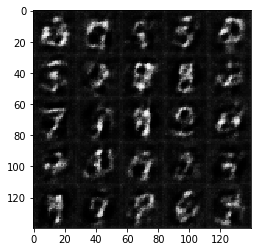

Epoch 1/2... batch: 185 Discriminator Loss: 1.1334... Generator Loss: 0.7694
Epoch 1/2... batch: 190 Discriminator Loss: 1.2762... Generator Loss: 2.3562
Epoch 1/2... batch: 195 Discriminator Loss: 1.7016... Generator Loss: 0.4261
Epoch 1/2... batch: 200 Discriminator Loss: 0.8908... Generator Loss: 1.4841
Epoch 1/2... batch: 205 Discriminator Loss: 0.9366... Generator Loss: 1.7564
Epoch 1/2... batch: 210 Discriminator Loss: 1.3538... Generator Loss: 3.1032
Epoch 1/2... batch: 215 Discriminator Loss: 1.2004... Generator Loss: 0.7552
Epoch 1/2... batch: 220 Discriminator Loss: 0.8915... Generator Loss: 1.4892
Epoch 1/2... batch: 225 Discriminator Loss: 1.1084... Generator Loss: 0.9555
Epoch 1/2... batch: 230 Discriminator Loss: 1.0064... Generator Loss: 1.0432
Epoch 1/2... batch: 235 Discriminator Loss: 0.9964... Generator Loss: 1.0799
Epoch 1/2... batch: 240 Discriminator Loss: 1.2366... Generator Loss: 2.4027


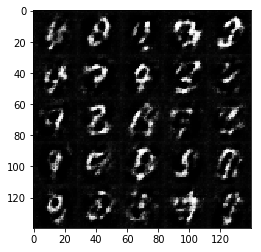

Epoch 1/2... batch: 245 Discriminator Loss: 0.8549... Generator Loss: 1.2955
Epoch 1/2... batch: 250 Discriminator Loss: 0.8884... Generator Loss: 1.4326
Epoch 1/2... batch: 255 Discriminator Loss: 1.0790... Generator Loss: 2.0025
Epoch 1/2... batch: 260 Discriminator Loss: 0.9463... Generator Loss: 1.6358
Epoch 1/2... batch: 265 Discriminator Loss: 1.2874... Generator Loss: 0.6219
Epoch 1/2... batch: 270 Discriminator Loss: 0.9478... Generator Loss: 2.4237
Epoch 1/2... batch: 275 Discriminator Loss: 0.9609... Generator Loss: 1.0467
Epoch 1/2... batch: 280 Discriminator Loss: 0.7527... Generator Loss: 1.7264
Epoch 1/2... batch: 285 Discriminator Loss: 1.0086... Generator Loss: 2.4967
Epoch 1/2... batch: 290 Discriminator Loss: 0.9604... Generator Loss: 1.7376
Epoch 1/2... batch: 295 Discriminator Loss: 0.8656... Generator Loss: 1.2160
Epoch 1/2... batch: 300 Discriminator Loss: 0.8282... Generator Loss: 2.1873


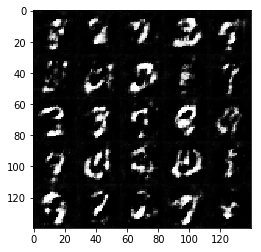

Epoch 1/2... batch: 305 Discriminator Loss: 0.8828... Generator Loss: 1.1662
Epoch 1/2... batch: 310 Discriminator Loss: 0.6435... Generator Loss: 1.8701
Epoch 1/2... batch: 315 Discriminator Loss: 0.8539... Generator Loss: 1.1072
Epoch 1/2... batch: 320 Discriminator Loss: 1.8496... Generator Loss: 0.3448
Epoch 1/2... batch: 325 Discriminator Loss: 1.3511... Generator Loss: 0.7058
Epoch 1/2... batch: 330 Discriminator Loss: 0.8986... Generator Loss: 1.7867
Epoch 1/2... batch: 335 Discriminator Loss: 0.6624... Generator Loss: 2.1015
Epoch 1/2... batch: 340 Discriminator Loss: 0.9437... Generator Loss: 0.9749
Epoch 1/2... batch: 345 Discriminator Loss: 1.1116... Generator Loss: 0.7503
Epoch 1/2... batch: 350 Discriminator Loss: 0.7816... Generator Loss: 1.2490
Epoch 1/2... batch: 355 Discriminator Loss: 0.7048... Generator Loss: 1.8896
Epoch 1/2... batch: 360 Discriminator Loss: 0.7420... Generator Loss: 2.4417


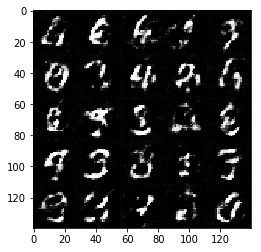

Epoch 1/2... batch: 365 Discriminator Loss: 0.7590... Generator Loss: 1.4655
Epoch 1/2... batch: 370 Discriminator Loss: 0.8430... Generator Loss: 2.4580
Epoch 1/2... batch: 375 Discriminator Loss: 0.7999... Generator Loss: 1.7345
Epoch 1/2... batch: 380 Discriminator Loss: 0.7268... Generator Loss: 1.4692
Epoch 1/2... batch: 385 Discriminator Loss: 0.7285... Generator Loss: 2.0502
Epoch 1/2... batch: 390 Discriminator Loss: 0.6471... Generator Loss: 1.6345
Epoch 1/2... batch: 395 Discriminator Loss: 0.8100... Generator Loss: 1.3309
Epoch 1/2... batch: 400 Discriminator Loss: 0.8437... Generator Loss: 1.1994
Epoch 1/2... batch: 405 Discriminator Loss: 0.9973... Generator Loss: 1.0613
Epoch 1/2... batch: 410 Discriminator Loss: 0.8847... Generator Loss: 2.2570
Epoch 1/2... batch: 415 Discriminator Loss: 0.6861... Generator Loss: 1.7722
Epoch 1/2... batch: 420 Discriminator Loss: 1.0711... Generator Loss: 0.9134


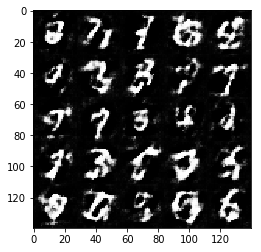

Epoch 1/2... batch: 425 Discriminator Loss: 0.6582... Generator Loss: 1.7169
Epoch 1/2... batch: 430 Discriminator Loss: 1.0326... Generator Loss: 0.8588
Epoch 1/2... batch: 435 Discriminator Loss: 0.7644... Generator Loss: 1.3377
Epoch 1/2... batch: 440 Discriminator Loss: 0.8589... Generator Loss: 1.2483
Epoch 1/2... batch: 445 Discriminator Loss: 0.5875... Generator Loss: 2.3423
Epoch 1/2... batch: 450 Discriminator Loss: 1.0096... Generator Loss: 1.1346
Epoch 1/2... batch: 455 Discriminator Loss: 0.8509... Generator Loss: 1.2636
Epoch 1/2... batch: 460 Discriminator Loss: 0.8750... Generator Loss: 1.3778
Epoch 1/2... batch: 465 Discriminator Loss: 0.8868... Generator Loss: 0.9786
Epoch 1/2... batch: 470 Discriminator Loss: 0.7332... Generator Loss: 1.8697
Epoch 1/2... batch: 475 Discriminator Loss: 0.6705... Generator Loss: 1.6814
Epoch 1/2... batch: 480 Discriminator Loss: 0.7803... Generator Loss: 1.5295


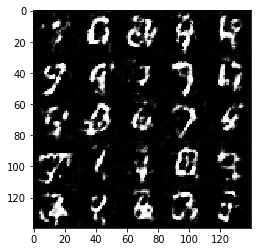

Epoch 1/2... batch: 485 Discriminator Loss: 0.8103... Generator Loss: 1.2789
Epoch 1/2... batch: 490 Discriminator Loss: 0.7242... Generator Loss: 1.4897
Epoch 1/2... batch: 495 Discriminator Loss: 0.9366... Generator Loss: 1.1453
Epoch 1/2... batch: 500 Discriminator Loss: 0.7823... Generator Loss: 1.4341
Epoch 1/2... batch: 505 Discriminator Loss: 1.0186... Generator Loss: 0.9072
Epoch 1/2... batch: 510 Discriminator Loss: 0.8505... Generator Loss: 1.2972
Epoch 1/2... batch: 515 Discriminator Loss: 0.8414... Generator Loss: 2.7376
Epoch 1/2... batch: 520 Discriminator Loss: 0.8674... Generator Loss: 1.2813
Epoch 1/2... batch: 525 Discriminator Loss: 1.4719... Generator Loss: 2.6860
Epoch 1/2... batch: 530 Discriminator Loss: 0.8611... Generator Loss: 1.4352
Epoch 1/2... batch: 535 Discriminator Loss: 0.8004... Generator Loss: 1.3798
Epoch 1/2... batch: 540 Discriminator Loss: 0.8166... Generator Loss: 1.3434


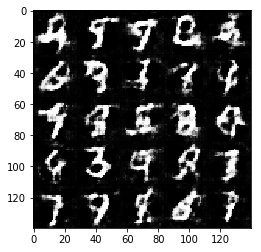

Epoch 1/2... batch: 545 Discriminator Loss: 0.6750... Generator Loss: 2.0048
Epoch 1/2... batch: 550 Discriminator Loss: 1.6860... Generator Loss: 0.4620
Epoch 1/2... batch: 555 Discriminator Loss: 1.2010... Generator Loss: 0.8180
Epoch 1/2... batch: 560 Discriminator Loss: 1.3756... Generator Loss: 0.5295
Epoch 1/2... batch: 565 Discriminator Loss: 0.7897... Generator Loss: 1.3625
Epoch 1/2... batch: 570 Discriminator Loss: 0.8833... Generator Loss: 1.2445
Epoch 1/2... batch: 575 Discriminator Loss: 1.3498... Generator Loss: 0.6256
Epoch 1/2... batch: 580 Discriminator Loss: 0.9223... Generator Loss: 1.0816
Epoch 1/2... batch: 585 Discriminator Loss: 0.9406... Generator Loss: 1.0204
Epoch 1/2... batch: 590 Discriminator Loss: 0.8165... Generator Loss: 1.5892
Epoch 1/2... batch: 595 Discriminator Loss: 0.7366... Generator Loss: 1.7473
Epoch 1/2... batch: 600 Discriminator Loss: 0.7563... Generator Loss: 2.7176


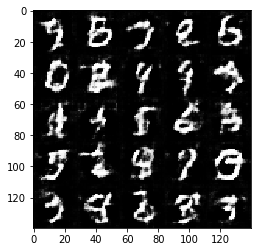

Epoch 1/2... batch: 605 Discriminator Loss: 1.0212... Generator Loss: 2.3284
Epoch 1/2... batch: 610 Discriminator Loss: 1.1364... Generator Loss: 0.7595
Epoch 1/2... batch: 615 Discriminator Loss: 0.8385... Generator Loss: 1.4192
Epoch 1/2... batch: 620 Discriminator Loss: 0.8107... Generator Loss: 1.8195
Epoch 1/2... batch: 625 Discriminator Loss: 0.7323... Generator Loss: 1.4574
Epoch 1/2... batch: 630 Discriminator Loss: 0.8963... Generator Loss: 1.1928
Epoch 1/2... batch: 635 Discriminator Loss: 0.7350... Generator Loss: 1.5828
Epoch 1/2... batch: 640 Discriminator Loss: 0.8885... Generator Loss: 2.7977
Epoch 1/2... batch: 645 Discriminator Loss: 1.1517... Generator Loss: 0.7535
Epoch 1/2... batch: 650 Discriminator Loss: 1.1457... Generator Loss: 0.7396
Epoch 1/2... batch: 655 Discriminator Loss: 0.9842... Generator Loss: 1.0366
Epoch 1/2... batch: 660 Discriminator Loss: 0.8179... Generator Loss: 1.6335


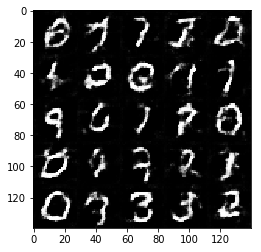

Epoch 1/2... batch: 665 Discriminator Loss: 0.8150... Generator Loss: 1.3246
Epoch 1/2... batch: 670 Discriminator Loss: 1.2357... Generator Loss: 0.7329
Epoch 1/2... batch: 675 Discriminator Loss: 1.1904... Generator Loss: 0.8782
Epoch 1/2... batch: 680 Discriminator Loss: 0.7820... Generator Loss: 1.4506
Epoch 1/2... batch: 685 Discriminator Loss: 1.0201... Generator Loss: 2.6426
Epoch 1/2... batch: 690 Discriminator Loss: 0.7861... Generator Loss: 1.6156
Epoch 1/2... batch: 695 Discriminator Loss: 0.9140... Generator Loss: 1.2016
Epoch 1/2... batch: 700 Discriminator Loss: 0.8819... Generator Loss: 1.3009
Epoch 1/2... batch: 705 Discriminator Loss: 0.9074... Generator Loss: 1.4236
Epoch 1/2... batch: 710 Discriminator Loss: 0.9550... Generator Loss: 2.3285
Epoch 1/2... batch: 715 Discriminator Loss: 0.8809... Generator Loss: 1.4457
Epoch 1/2... batch: 720 Discriminator Loss: 1.0684... Generator Loss: 1.0078


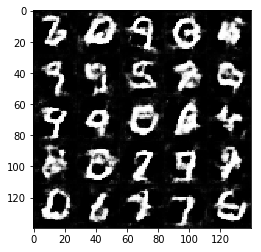

Epoch 1/2... batch: 725 Discriminator Loss: 0.7716... Generator Loss: 1.4060
Epoch 1/2... batch: 730 Discriminator Loss: 0.9587... Generator Loss: 1.0081
Epoch 1/2... batch: 735 Discriminator Loss: 0.7369... Generator Loss: 1.4496
Epoch 1/2... batch: 740 Discriminator Loss: 0.9556... Generator Loss: 1.2670
Epoch 1/2... batch: 745 Discriminator Loss: 0.8469... Generator Loss: 1.4588
Epoch 1/2... batch: 750 Discriminator Loss: 0.8899... Generator Loss: 1.4018
Epoch 1/2... batch: 755 Discriminator Loss: 0.9084... Generator Loss: 2.0596
Epoch 1/2... batch: 760 Discriminator Loss: 0.7061... Generator Loss: 1.6392
Epoch 1/2... batch: 765 Discriminator Loss: 1.0027... Generator Loss: 1.0026
Epoch 1/2... batch: 770 Discriminator Loss: 1.1423... Generator Loss: 0.8852
Epoch 1/2... batch: 775 Discriminator Loss: 0.9020... Generator Loss: 1.1740
Epoch 1/2... batch: 780 Discriminator Loss: 0.8799... Generator Loss: 1.1908


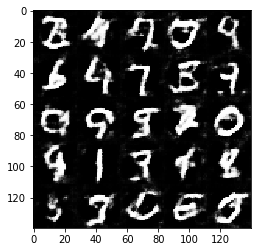

Epoch 1/2... batch: 785 Discriminator Loss: 1.0334... Generator Loss: 0.9720
Epoch 1/2... batch: 790 Discriminator Loss: 0.9496... Generator Loss: 1.1638
Epoch 1/2... batch: 795 Discriminator Loss: 1.0414... Generator Loss: 0.9917
Epoch 1/2... batch: 800 Discriminator Loss: 0.9425... Generator Loss: 1.1038
Epoch 1/2... batch: 805 Discriminator Loss: 1.4120... Generator Loss: 0.6524
Epoch 1/2... batch: 810 Discriminator Loss: 0.7710... Generator Loss: 1.4675
Epoch 1/2... batch: 815 Discriminator Loss: 0.9764... Generator Loss: 0.9282
Epoch 1/2... batch: 820 Discriminator Loss: 1.2249... Generator Loss: 0.5833
Epoch 1/2... batch: 825 Discriminator Loss: 1.3501... Generator Loss: 0.5831
Epoch 1/2... batch: 830 Discriminator Loss: 0.9174... Generator Loss: 1.2055
Epoch 1/2... batch: 835 Discriminator Loss: 0.9882... Generator Loss: 1.3035
Epoch 1/2... batch: 840 Discriminator Loss: 1.1810... Generator Loss: 0.9401


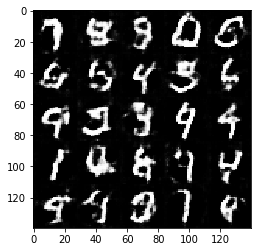

Epoch 1/2... batch: 845 Discriminator Loss: 0.8697... Generator Loss: 1.1770
Epoch 1/2... batch: 850 Discriminator Loss: 0.8574... Generator Loss: 1.2121
Epoch 1/2... batch: 855 Discriminator Loss: 0.7302... Generator Loss: 2.2470
Epoch 1/2... batch: 860 Discriminator Loss: 0.7285... Generator Loss: 1.6066
Epoch 1/2... batch: 865 Discriminator Loss: 1.1526... Generator Loss: 0.6925
Epoch 1/2... batch: 870 Discriminator Loss: 1.0938... Generator Loss: 0.8722
Epoch 1/2... batch: 875 Discriminator Loss: 0.9143... Generator Loss: 1.0642
Epoch 1/2... batch: 880 Discriminator Loss: 0.8032... Generator Loss: 1.5002
Epoch 1/2... batch: 885 Discriminator Loss: 1.0360... Generator Loss: 3.2143
Epoch 1/2... batch: 890 Discriminator Loss: 0.8620... Generator Loss: 1.1579
Epoch 1/2... batch: 895 Discriminator Loss: 0.9052... Generator Loss: 1.7424
Epoch 1/2... batch: 900 Discriminator Loss: 0.6274... Generator Loss: 1.8427


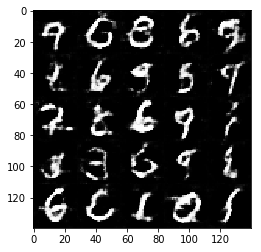

Epoch 1/2... batch: 905 Discriminator Loss: 1.0037... Generator Loss: 1.5664
Epoch 1/2... batch: 910 Discriminator Loss: 1.4141... Generator Loss: 0.5677
Epoch 1/2... batch: 915 Discriminator Loss: 1.1984... Generator Loss: 0.7020
Epoch 1/2... batch: 920 Discriminator Loss: 0.8212... Generator Loss: 1.5944
Epoch 1/2... batch: 925 Discriminator Loss: 0.6857... Generator Loss: 1.9419
Epoch 1/2... batch: 930 Discriminator Loss: 0.9453... Generator Loss: 1.0774
Epoch 1/2... batch: 935 Discriminator Loss: 1.0997... Generator Loss: 2.4304
Epoch 1/2... batch: 940 Discriminator Loss: 1.0444... Generator Loss: 0.9542
Epoch 1/2... batch: 945 Discriminator Loss: 1.0241... Generator Loss: 1.0339
Epoch 1/2... batch: 950 Discriminator Loss: 0.9738... Generator Loss: 1.3003
Epoch 1/2... batch: 955 Discriminator Loss: 1.0488... Generator Loss: 0.9456
Epoch 1/2... batch: 960 Discriminator Loss: 0.6778... Generator Loss: 1.6265


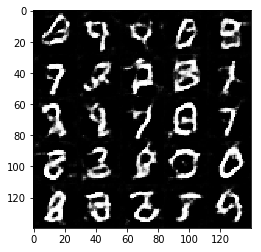

Epoch 1/2... batch: 965 Discriminator Loss: 0.8688... Generator Loss: 1.0917
Epoch 1/2... batch: 970 Discriminator Loss: 1.2758... Generator Loss: 0.7416
Epoch 1/2... batch: 975 Discriminator Loss: 0.7630... Generator Loss: 1.4362
Epoch 1/2... batch: 980 Discriminator Loss: 0.8517... Generator Loss: 2.1202
Epoch 1/2... batch: 985 Discriminator Loss: 0.8034... Generator Loss: 1.2678
Epoch 1/2... batch: 990 Discriminator Loss: 0.8595... Generator Loss: 1.1197
Epoch 1/2... batch: 995 Discriminator Loss: 0.8951... Generator Loss: 1.2190
Epoch 1/2... batch: 1000 Discriminator Loss: 1.2506... Generator Loss: 2.5327
Epoch 1/2... batch: 1005 Discriminator Loss: 0.9275... Generator Loss: 1.5745
Epoch 1/2... batch: 1010 Discriminator Loss: 1.2816... Generator Loss: 0.6224
Epoch 1/2... batch: 1015 Discriminator Loss: 0.7777... Generator Loss: 1.2883
Epoch 1/2... batch: 1020 Discriminator Loss: 0.8516... Generator Loss: 1.2999


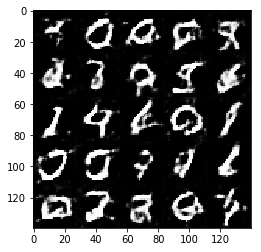

Epoch 1/2... batch: 1025 Discriminator Loss: 0.9186... Generator Loss: 1.1663
Epoch 1/2... batch: 1030 Discriminator Loss: 0.9578... Generator Loss: 0.9435
Epoch 1/2... batch: 1035 Discriminator Loss: 1.7560... Generator Loss: 0.5087
Epoch 1/2... batch: 1040 Discriminator Loss: 0.6862... Generator Loss: 1.6780
Epoch 1/2... batch: 1045 Discriminator Loss: 0.8285... Generator Loss: 1.1536
Epoch 1/2... batch: 1050 Discriminator Loss: 1.3682... Generator Loss: 0.6066
Epoch 1/2... batch: 1055 Discriminator Loss: 1.0646... Generator Loss: 1.7744
Epoch 1/2... batch: 1060 Discriminator Loss: 1.8444... Generator Loss: 3.0089
Epoch 1/2... batch: 1065 Discriminator Loss: 0.9088... Generator Loss: 1.1989
Epoch 1/2... batch: 1070 Discriminator Loss: 0.8181... Generator Loss: 1.1890
Epoch 1/2... batch: 1075 Discriminator Loss: 0.8365... Generator Loss: 1.2540
Epoch 1/2... batch: 1080 Discriminator Loss: 0.8776... Generator Loss: 1.2568


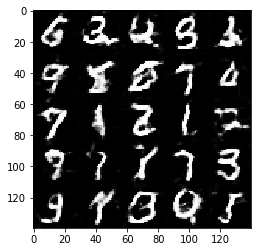

Epoch 1/2... batch: 1085 Discriminator Loss: 1.2181... Generator Loss: 0.5465
Epoch 1/2... batch: 1090 Discriminator Loss: 1.1583... Generator Loss: 0.7153
Epoch 1/2... batch: 1095 Discriminator Loss: 0.8222... Generator Loss: 1.6280
Epoch 1/2... batch: 1100 Discriminator Loss: 0.7698... Generator Loss: 1.5200
Epoch 1/2... batch: 1105 Discriminator Loss: 0.9713... Generator Loss: 1.0128
Epoch 1/2... batch: 1110 Discriminator Loss: 0.9306... Generator Loss: 1.0887
Epoch 1/2... batch: 1115 Discriminator Loss: 0.6612... Generator Loss: 1.9013
Epoch 1/2... batch: 1120 Discriminator Loss: 0.7949... Generator Loss: 1.4295
Epoch 1/2... batch: 1125 Discriminator Loss: 0.7177... Generator Loss: 1.5270
Epoch 1/2... batch: 1130 Discriminator Loss: 1.4129... Generator Loss: 0.6074
Epoch 1/2... batch: 1135 Discriminator Loss: 0.7337... Generator Loss: 1.3840
Epoch 1/2... batch: 1140 Discriminator Loss: 0.6846... Generator Loss: 2.2702


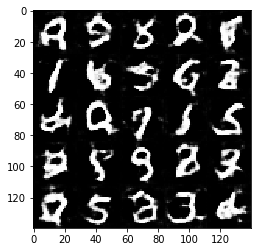

Epoch 1/2... batch: 1145 Discriminator Loss: 0.9153... Generator Loss: 2.3231
Epoch 1/2... batch: 1150 Discriminator Loss: 0.8698... Generator Loss: 1.1749
Epoch 1/2... batch: 1155 Discriminator Loss: 0.7765... Generator Loss: 1.5791
Epoch 1/2... batch: 1160 Discriminator Loss: 1.2667... Generator Loss: 2.0569
Epoch 1/2... batch: 1165 Discriminator Loss: 1.2170... Generator Loss: 0.7076
Epoch 1/2... batch: 1170 Discriminator Loss: 0.8514... Generator Loss: 1.4984
Epoch 1/2... batch: 1175 Discriminator Loss: 0.8846... Generator Loss: 1.1894
Epoch 1/2... batch: 1180 Discriminator Loss: 1.0623... Generator Loss: 0.9581
Epoch 1/2... batch: 1185 Discriminator Loss: 0.8131... Generator Loss: 1.2621
Epoch 1/2... batch: 1190 Discriminator Loss: 0.7995... Generator Loss: 1.2797
Epoch 1/2... batch: 1195 Discriminator Loss: 0.9581... Generator Loss: 1.0301
Epoch 1/2... batch: 1200 Discriminator Loss: 0.7766... Generator Loss: 1.4294


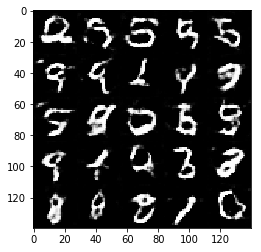

Epoch 1/2... batch: 1205 Discriminator Loss: 0.7061... Generator Loss: 1.7247
Epoch 1/2... batch: 1210 Discriminator Loss: 0.7910... Generator Loss: 1.2308
Epoch 1/2... batch: 1215 Discriminator Loss: 0.7405... Generator Loss: 1.7018
Epoch 1/2... batch: 1220 Discriminator Loss: 0.7746... Generator Loss: 1.6753
Epoch 1/2... batch: 1225 Discriminator Loss: 0.8939... Generator Loss: 1.1062
Epoch 1/2... batch: 1230 Discriminator Loss: 1.1347... Generator Loss: 0.8427
Epoch 1/2... batch: 1235 Discriminator Loss: 2.5367... Generator Loss: 3.9615
Epoch 1/2... batch: 1240 Discriminator Loss: 1.2741... Generator Loss: 0.7745
Epoch 1/2... batch: 1245 Discriminator Loss: 1.1704... Generator Loss: 1.0131
Epoch 1/2... batch: 1250 Discriminator Loss: 0.9517... Generator Loss: 1.1952
Epoch 1/2... batch: 1255 Discriminator Loss: 0.9805... Generator Loss: 0.9902
Epoch 1/2... batch: 1260 Discriminator Loss: 1.1737... Generator Loss: 0.7099


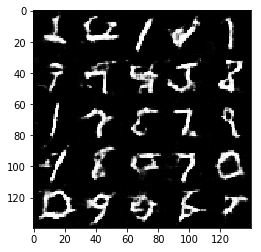

Epoch 1/2... batch: 1265 Discriminator Loss: 0.7833... Generator Loss: 1.3845
Epoch 1/2... batch: 1270 Discriminator Loss: 0.7606... Generator Loss: 1.4819
Epoch 1/2... batch: 1275 Discriminator Loss: 0.6313... Generator Loss: 1.7947
Epoch 1/2... batch: 1280 Discriminator Loss: 1.0438... Generator Loss: 0.9171
Epoch 1/2... batch: 1285 Discriminator Loss: 0.9869... Generator Loss: 0.8787
Epoch 1/2... batch: 1290 Discriminator Loss: 0.9102... Generator Loss: 1.2545
Epoch 1/2... batch: 1295 Discriminator Loss: 0.7326... Generator Loss: 1.4047
Epoch 1/2... batch: 1300 Discriminator Loss: 0.9127... Generator Loss: 1.1790
Epoch 1/2... batch: 1305 Discriminator Loss: 0.7263... Generator Loss: 1.7213
Epoch 1/2... batch: 1310 Discriminator Loss: 1.0889... Generator Loss: 0.7225
Epoch 1/2... batch: 1315 Discriminator Loss: 0.8205... Generator Loss: 1.2865
Epoch 1/2... batch: 1320 Discriminator Loss: 1.1707... Generator Loss: 0.7708


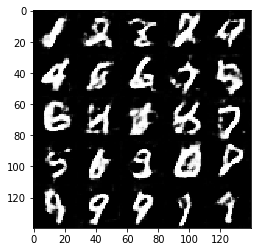

Epoch 1/2... batch: 1325 Discriminator Loss: 0.7554... Generator Loss: 1.4358
Epoch 1/2... batch: 1330 Discriminator Loss: 1.6256... Generator Loss: 0.4490
Epoch 1/2... batch: 1335 Discriminator Loss: 1.0681... Generator Loss: 0.8295
Epoch 1/2... batch: 1340 Discriminator Loss: 0.8540... Generator Loss: 1.2092
Epoch 1/2... batch: 1345 Discriminator Loss: 0.9388... Generator Loss: 1.0335
Epoch 1/2... batch: 1350 Discriminator Loss: 0.7709... Generator Loss: 1.7563
Epoch 1/2... batch: 1355 Discriminator Loss: 0.8577... Generator Loss: 1.3627
Epoch 1/2... batch: 1360 Discriminator Loss: 0.7726... Generator Loss: 1.3654
Epoch 1/2... batch: 1365 Discriminator Loss: 0.6744... Generator Loss: 1.6038
Epoch 1/2... batch: 1370 Discriminator Loss: 0.7204... Generator Loss: 1.4227
Epoch 1/2... batch: 1375 Discriminator Loss: 0.7227... Generator Loss: 1.5704
Epoch 1/2... batch: 1380 Discriminator Loss: 0.7858... Generator Loss: 1.2523


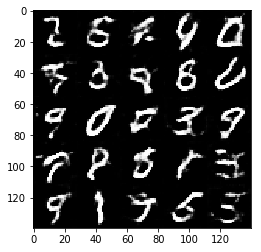

Epoch 1/2... batch: 1385 Discriminator Loss: 0.6596... Generator Loss: 1.8479
Epoch 1/2... batch: 1390 Discriminator Loss: 0.8604... Generator Loss: 1.0762
Epoch 1/2... batch: 1395 Discriminator Loss: 0.9790... Generator Loss: 0.8434
Epoch 1/2... batch: 1400 Discriminator Loss: 0.6515... Generator Loss: 1.6437
Epoch 1/2... batch: 1405 Discriminator Loss: 0.9628... Generator Loss: 1.0330
Epoch 1/2... batch: 1410 Discriminator Loss: 1.1290... Generator Loss: 0.8753
Epoch 1/2... batch: 1415 Discriminator Loss: 0.7110... Generator Loss: 1.7135
Epoch 1/2... batch: 1420 Discriminator Loss: 0.7505... Generator Loss: 1.3719
Epoch 1/2... batch: 1425 Discriminator Loss: 0.7151... Generator Loss: 1.5946
Epoch 1/2... batch: 1430 Discriminator Loss: 0.9076... Generator Loss: 1.2539
Epoch 1/2... batch: 1435 Discriminator Loss: 2.2394... Generator Loss: 3.4962
Epoch 1/2... batch: 1440 Discriminator Loss: 0.8720... Generator Loss: 1.3167


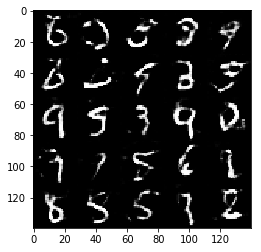

Epoch 1/2... batch: 1445 Discriminator Loss: 0.7372... Generator Loss: 1.8845
Epoch 1/2... batch: 1450 Discriminator Loss: 0.9276... Generator Loss: 1.1503
Epoch 1/2... batch: 1455 Discriminator Loss: 0.8772... Generator Loss: 1.2166
Epoch 1/2... batch: 1460 Discriminator Loss: 1.1220... Generator Loss: 0.7871
Epoch 1/2... batch: 1465 Discriminator Loss: 0.7435... Generator Loss: 1.6277
Epoch 1/2... batch: 1470 Discriminator Loss: 1.3620... Generator Loss: 0.6481
Epoch 1/2... batch: 1475 Discriminator Loss: 0.9347... Generator Loss: 1.9021
Epoch 1/2... batch: 1480 Discriminator Loss: 0.7788... Generator Loss: 1.3092
Epoch 1/2... batch: 1485 Discriminator Loss: 0.8767... Generator Loss: 1.1960
Epoch 1/2... batch: 1490 Discriminator Loss: 0.7658... Generator Loss: 1.5343
Epoch 1/2... batch: 1495 Discriminator Loss: 1.0431... Generator Loss: 0.9832
Epoch 1/2... batch: 1500 Discriminator Loss: 0.7787... Generator Loss: 1.2945


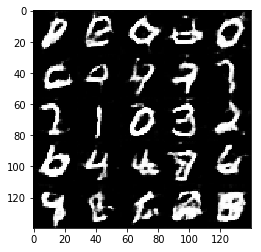

Epoch 1/2... batch: 1505 Discriminator Loss: 0.8117... Generator Loss: 1.8385
Epoch 1/2... batch: 1510 Discriminator Loss: 1.1896... Generator Loss: 0.6517
Epoch 1/2... batch: 1515 Discriminator Loss: 0.9750... Generator Loss: 0.9963
Epoch 1/2... batch: 1520 Discriminator Loss: 0.7973... Generator Loss: 1.5650
Epoch 1/2... batch: 1525 Discriminator Loss: 0.8420... Generator Loss: 1.1086
Epoch 1/2... batch: 1530 Discriminator Loss: 1.3684... Generator Loss: 0.6938
Epoch 1/2... batch: 1535 Discriminator Loss: 1.3342... Generator Loss: 0.6697
Epoch 1/2... batch: 1540 Discriminator Loss: 0.8965... Generator Loss: 0.9486
Epoch 1/2... batch: 1545 Discriminator Loss: 0.9150... Generator Loss: 1.0004
Epoch 1/2... batch: 1550 Discriminator Loss: 0.7481... Generator Loss: 1.3480
Epoch 1/2... batch: 1555 Discriminator Loss: 0.8878... Generator Loss: 1.0550
Epoch 1/2... batch: 1560 Discriminator Loss: 1.3081... Generator Loss: 0.6159


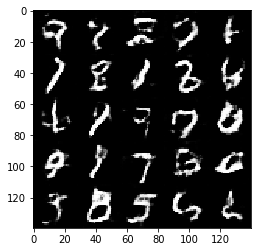

Epoch 1/2... batch: 1565 Discriminator Loss: 0.6639... Generator Loss: 1.6285
Epoch 1/2... batch: 1570 Discriminator Loss: 0.8269... Generator Loss: 1.4626
Epoch 1/2... batch: 1575 Discriminator Loss: 0.8208... Generator Loss: 1.5545
Epoch 1/2... batch: 1580 Discriminator Loss: 0.8054... Generator Loss: 1.1809
Epoch 1/2... batch: 1585 Discriminator Loss: 0.7224... Generator Loss: 1.4153
Epoch 1/2... batch: 1590 Discriminator Loss: 1.0109... Generator Loss: 0.8788
Epoch 1/2... batch: 1595 Discriminator Loss: 0.7136... Generator Loss: 1.5323
Epoch 1/2... batch: 1600 Discriminator Loss: 1.2825... Generator Loss: 3.2568
Epoch 1/2... batch: 1605 Discriminator Loss: 2.7744... Generator Loss: 0.2577
Epoch 1/2... batch: 1610 Discriminator Loss: 0.9668... Generator Loss: 2.3032
Epoch 1/2... batch: 1615 Discriminator Loss: 1.1541... Generator Loss: 0.7618
Epoch 1/2... batch: 1620 Discriminator Loss: 0.6604... Generator Loss: 1.8941


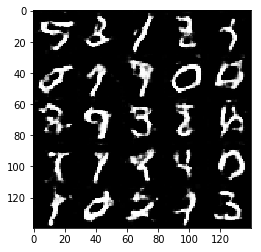

Epoch 1/2... batch: 1625 Discriminator Loss: 0.8905... Generator Loss: 1.1788
Epoch 1/2... batch: 1630 Discriminator Loss: 0.9602... Generator Loss: 1.0858
Epoch 1/2... batch: 1635 Discriminator Loss: 0.9428... Generator Loss: 1.0663
Epoch 1/2... batch: 1640 Discriminator Loss: 0.9292... Generator Loss: 1.0979
Epoch 1/2... batch: 1645 Discriminator Loss: 0.6520... Generator Loss: 1.9692
Epoch 1/2... batch: 1650 Discriminator Loss: 0.7318... Generator Loss: 1.3114
Epoch 1/2... batch: 1655 Discriminator Loss: 1.3245... Generator Loss: 0.6081
Epoch 1/2... batch: 1660 Discriminator Loss: 0.6869... Generator Loss: 1.5456
Epoch 1/2... batch: 1665 Discriminator Loss: 0.7274... Generator Loss: 1.4537
Epoch 1/2... batch: 1670 Discriminator Loss: 0.5884... Generator Loss: 1.9026
Epoch 1/2... batch: 1675 Discriminator Loss: 0.6965... Generator Loss: 1.5183
Epoch 1/2... batch: 1680 Discriminator Loss: 0.8432... Generator Loss: 1.1301


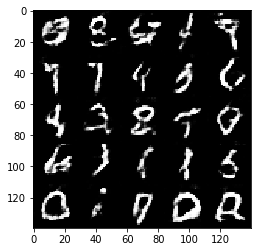

Epoch 1/2... batch: 1685 Discriminator Loss: 1.0491... Generator Loss: 0.8224
Epoch 1/2... batch: 1690 Discriminator Loss: 0.7649... Generator Loss: 1.9386
Epoch 1/2... batch: 1695 Discriminator Loss: 0.7939... Generator Loss: 1.2904
Epoch 1/2... batch: 1700 Discriminator Loss: 1.0327... Generator Loss: 0.8520
Epoch 1/2... batch: 1705 Discriminator Loss: 0.9861... Generator Loss: 0.9985
Epoch 1/2... batch: 1710 Discriminator Loss: 0.6737... Generator Loss: 1.5647
Epoch 1/2... batch: 1715 Discriminator Loss: 1.0696... Generator Loss: 2.5297
Epoch 1/2... batch: 1720 Discriminator Loss: 0.9456... Generator Loss: 1.6846
Epoch 1/2... batch: 1725 Discriminator Loss: 1.0589... Generator Loss: 0.8558
Epoch 1/2... batch: 1730 Discriminator Loss: 1.5875... Generator Loss: 0.5245
Epoch 1/2... batch: 1735 Discriminator Loss: 1.3244... Generator Loss: 0.6234
Epoch 1/2... batch: 1740 Discriminator Loss: 1.6129... Generator Loss: 0.4454


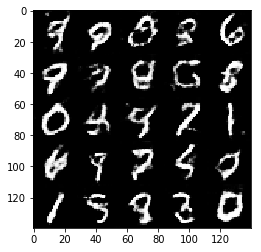

Epoch 1/2... batch: 1745 Discriminator Loss: 0.7209... Generator Loss: 1.7736
Epoch 1/2... batch: 1750 Discriminator Loss: 0.7972... Generator Loss: 1.2859
Epoch 1/2... batch: 1755 Discriminator Loss: 1.1882... Generator Loss: 0.7385
Epoch 1/2... batch: 1760 Discriminator Loss: 0.6482... Generator Loss: 1.9267
Epoch 1/2... batch: 1765 Discriminator Loss: 1.1428... Generator Loss: 0.7073
Epoch 1/2... batch: 1770 Discriminator Loss: 0.7888... Generator Loss: 1.2471
Epoch 1/2... batch: 1775 Discriminator Loss: 0.7241... Generator Loss: 1.9247
Epoch 1/2... batch: 1780 Discriminator Loss: 0.6331... Generator Loss: 2.1152
Epoch 1/2... batch: 1785 Discriminator Loss: 0.5946... Generator Loss: 2.0277
Epoch 1/2... batch: 1790 Discriminator Loss: 0.6448... Generator Loss: 1.6126
Epoch 1/2... batch: 1795 Discriminator Loss: 0.7616... Generator Loss: 1.4329
Epoch 1/2... batch: 1800 Discriminator Loss: 0.7517... Generator Loss: 1.4610


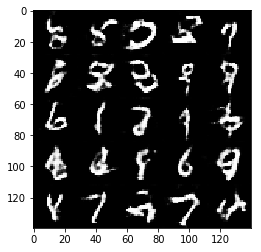

Epoch 1/2... batch: 1805 Discriminator Loss: 0.8479... Generator Loss: 1.0387
Epoch 1/2... batch: 1810 Discriminator Loss: 0.7764... Generator Loss: 1.3466
Epoch 1/2... batch: 1815 Discriminator Loss: 0.7836... Generator Loss: 1.4419
Epoch 1/2... batch: 1820 Discriminator Loss: 0.9557... Generator Loss: 1.1170
Epoch 1/2... batch: 1825 Discriminator Loss: 0.6517... Generator Loss: 1.7509
Epoch 1/2... batch: 1830 Discriminator Loss: 1.5358... Generator Loss: 0.5053
Epoch 1/2... batch: 1835 Discriminator Loss: 0.8149... Generator Loss: 1.3702
Epoch 1/2... batch: 1840 Discriminator Loss: 0.8112... Generator Loss: 2.4527
Epoch 1/2... batch: 1845 Discriminator Loss: 1.5157... Generator Loss: 0.5426
Epoch 1/2... batch: 1850 Discriminator Loss: 0.6227... Generator Loss: 1.7680
Epoch 1/2... batch: 1855 Discriminator Loss: 0.7438... Generator Loss: 1.8880
Epoch 1/2... batch: 1860 Discriminator Loss: 1.8536... Generator Loss: 0.4603


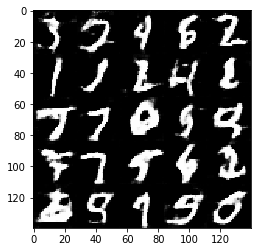

Epoch 1/2... batch: 1865 Discriminator Loss: 0.7823... Generator Loss: 1.4571
Epoch 1/2... batch: 1870 Discriminator Loss: 1.6429... Generator Loss: 0.4959
Epoch 1/2... batch: 1875 Discriminator Loss: 0.5938... Generator Loss: 1.9975
Epoch 2/2... batch: 5 Discriminator Loss: 0.7722... Generator Loss: 1.5059
Epoch 2/2... batch: 10 Discriminator Loss: 0.8252... Generator Loss: 1.5865
Epoch 2/2... batch: 15 Discriminator Loss: 0.8062... Generator Loss: 1.2423
Epoch 2/2... batch: 20 Discriminator Loss: 0.7589... Generator Loss: 1.5200
Epoch 2/2... batch: 25 Discriminator Loss: 0.8893... Generator Loss: 1.0950
Epoch 2/2... batch: 30 Discriminator Loss: 0.6725... Generator Loss: 1.7006
Epoch 2/2... batch: 35 Discriminator Loss: 0.8116... Generator Loss: 1.4431
Epoch 2/2... batch: 40 Discriminator Loss: 1.7985... Generator Loss: 3.1586
Epoch 2/2... batch: 45 Discriminator Loss: 1.1169... Generator Loss: 0.8106


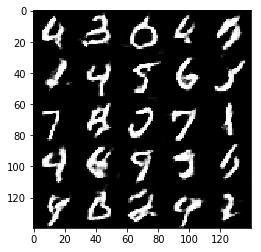

Epoch 2/2... batch: 50 Discriminator Loss: 1.0229... Generator Loss: 1.0838
Epoch 2/2... batch: 55 Discriminator Loss: 0.9288... Generator Loss: 1.2205
Epoch 2/2... batch: 60 Discriminator Loss: 0.6819... Generator Loss: 1.6583
Epoch 2/2... batch: 65 Discriminator Loss: 0.7518... Generator Loss: 1.5464
Epoch 2/2... batch: 70 Discriminator Loss: 0.7982... Generator Loss: 2.6115
Epoch 2/2... batch: 75 Discriminator Loss: 0.6822... Generator Loss: 1.8592
Epoch 2/2... batch: 80 Discriminator Loss: 0.6450... Generator Loss: 1.8382
Epoch 2/2... batch: 85 Discriminator Loss: 0.6730... Generator Loss: 1.5777
Epoch 2/2... batch: 90 Discriminator Loss: 1.0060... Generator Loss: 0.8877
Epoch 2/2... batch: 95 Discriminator Loss: 1.2553... Generator Loss: 0.6471
Epoch 2/2... batch: 100 Discriminator Loss: 0.7918... Generator Loss: 1.2539
Epoch 2/2... batch: 105 Discriminator Loss: 0.7024... Generator Loss: 1.6570


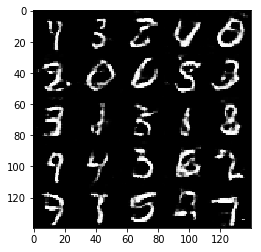

Epoch 2/2... batch: 110 Discriminator Loss: 0.6892... Generator Loss: 1.4693
Epoch 2/2... batch: 115 Discriminator Loss: 0.8341... Generator Loss: 1.1660
Epoch 2/2... batch: 120 Discriminator Loss: 0.7658... Generator Loss: 1.3271
Epoch 2/2... batch: 125 Discriminator Loss: 0.8206... Generator Loss: 1.1703
Epoch 2/2... batch: 130 Discriminator Loss: 0.7366... Generator Loss: 1.3708
Epoch 2/2... batch: 135 Discriminator Loss: 0.7710... Generator Loss: 1.2171
Epoch 2/2... batch: 140 Discriminator Loss: 0.7147... Generator Loss: 1.4808
Epoch 2/2... batch: 145 Discriminator Loss: 2.0476... Generator Loss: 0.3629
Epoch 2/2... batch: 150 Discriminator Loss: 0.8579... Generator Loss: 2.8340
Epoch 2/2... batch: 155 Discriminator Loss: 1.3246... Generator Loss: 0.7528
Epoch 2/2... batch: 160 Discriminator Loss: 0.9873... Generator Loss: 0.9756
Epoch 2/2... batch: 165 Discriminator Loss: 0.9260... Generator Loss: 1.0623


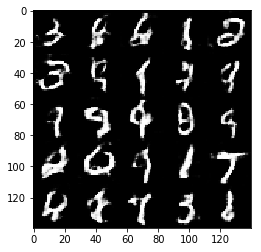

Epoch 2/2... batch: 170 Discriminator Loss: 1.3540... Generator Loss: 0.6934
Epoch 2/2... batch: 175 Discriminator Loss: 0.5833... Generator Loss: 2.2062
Epoch 2/2... batch: 180 Discriminator Loss: 0.9155... Generator Loss: 1.0109
Epoch 2/2... batch: 185 Discriminator Loss: 0.8202... Generator Loss: 1.1570
Epoch 2/2... batch: 190 Discriminator Loss: 0.7013... Generator Loss: 2.1840
Epoch 2/2... batch: 195 Discriminator Loss: 1.1920... Generator Loss: 0.7595
Epoch 2/2... batch: 200 Discriminator Loss: 0.6288... Generator Loss: 2.3639
Epoch 2/2... batch: 205 Discriminator Loss: 0.7264... Generator Loss: 1.9192
Epoch 2/2... batch: 210 Discriminator Loss: 0.6541... Generator Loss: 1.6545
Epoch 2/2... batch: 215 Discriminator Loss: 1.2627... Generator Loss: 0.5736
Epoch 2/2... batch: 220 Discriminator Loss: 0.8320... Generator Loss: 1.3447
Epoch 2/2... batch: 225 Discriminator Loss: 0.6919... Generator Loss: 1.4979


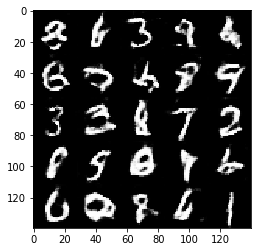

Epoch 2/2... batch: 230 Discriminator Loss: 0.6753... Generator Loss: 1.4944
Epoch 2/2... batch: 235 Discriminator Loss: 0.7736... Generator Loss: 1.5129
Epoch 2/2... batch: 240 Discriminator Loss: 0.7163... Generator Loss: 1.6527
Epoch 2/2... batch: 245 Discriminator Loss: 0.6930... Generator Loss: 1.5524
Epoch 2/2... batch: 250 Discriminator Loss: 0.9487... Generator Loss: 1.0682
Epoch 2/2... batch: 255 Discriminator Loss: 0.8590... Generator Loss: 0.9734
Epoch 2/2... batch: 260 Discriminator Loss: 0.5605... Generator Loss: 2.0273
Epoch 2/2... batch: 265 Discriminator Loss: 1.1213... Generator Loss: 0.7465
Epoch 2/2... batch: 270 Discriminator Loss: 1.0851... Generator Loss: 1.2320
Epoch 2/2... batch: 275 Discriminator Loss: 0.7399... Generator Loss: 2.0150
Epoch 2/2... batch: 280 Discriminator Loss: 0.7984... Generator Loss: 1.2999
Epoch 2/2... batch: 285 Discriminator Loss: 0.9697... Generator Loss: 2.3182


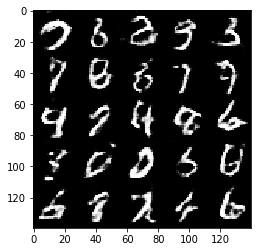

Epoch 2/2... batch: 290 Discriminator Loss: 1.1650... Generator Loss: 0.8350
Epoch 2/2... batch: 295 Discriminator Loss: 0.9394... Generator Loss: 1.0155
Epoch 2/2... batch: 300 Discriminator Loss: 0.7933... Generator Loss: 1.4193
Epoch 2/2... batch: 305 Discriminator Loss: 0.6886... Generator Loss: 1.5443
Epoch 2/2... batch: 310 Discriminator Loss: 0.7229... Generator Loss: 1.5468
Epoch 2/2... batch: 315 Discriminator Loss: 0.6366... Generator Loss: 1.5366
Epoch 2/2... batch: 320 Discriminator Loss: 1.3634... Generator Loss: 0.5520
Epoch 2/2... batch: 325 Discriminator Loss: 0.9278... Generator Loss: 1.8670
Epoch 2/2... batch: 330 Discriminator Loss: 0.6939... Generator Loss: 1.7787
Epoch 2/2... batch: 335 Discriminator Loss: 0.6188... Generator Loss: 1.7432
Epoch 2/2... batch: 340 Discriminator Loss: 0.7338... Generator Loss: 1.5538
Epoch 2/2... batch: 345 Discriminator Loss: 1.1336... Generator Loss: 0.7592


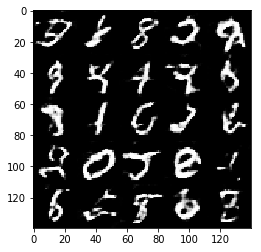

Epoch 2/2... batch: 350 Discriminator Loss: 0.7290... Generator Loss: 1.2701
Epoch 2/2... batch: 355 Discriminator Loss: 0.7169... Generator Loss: 1.5099
Epoch 2/2... batch: 360 Discriminator Loss: 0.8710... Generator Loss: 1.0256
Epoch 2/2... batch: 365 Discriminator Loss: 0.8502... Generator Loss: 1.1768
Epoch 2/2... batch: 370 Discriminator Loss: 0.8769... Generator Loss: 1.1006
Epoch 2/2... batch: 375 Discriminator Loss: 1.1663... Generator Loss: 0.7777
Epoch 2/2... batch: 380 Discriminator Loss: 0.6222... Generator Loss: 1.9005
Epoch 2/2... batch: 385 Discriminator Loss: 0.7377... Generator Loss: 1.3796
Epoch 2/2... batch: 390 Discriminator Loss: 1.3579... Generator Loss: 0.5777
Epoch 2/2... batch: 395 Discriminator Loss: 0.7808... Generator Loss: 1.3465
Epoch 2/2... batch: 400 Discriminator Loss: 0.7411... Generator Loss: 1.3821
Epoch 2/2... batch: 405 Discriminator Loss: 1.2247... Generator Loss: 0.7531


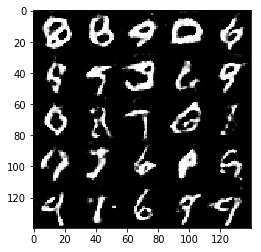

Epoch 2/2... batch: 410 Discriminator Loss: 1.1000... Generator Loss: 0.8305
Epoch 2/2... batch: 415 Discriminator Loss: 0.8912... Generator Loss: 1.0158
Epoch 2/2... batch: 420 Discriminator Loss: 0.6378... Generator Loss: 2.4027
Epoch 2/2... batch: 425 Discriminator Loss: 0.7834... Generator Loss: 1.2597
Epoch 2/2... batch: 430 Discriminator Loss: 0.8605... Generator Loss: 1.0189
Epoch 2/2... batch: 435 Discriminator Loss: 0.6535... Generator Loss: 1.9319
Epoch 2/2... batch: 440 Discriminator Loss: 1.0448... Generator Loss: 0.9210
Epoch 2/2... batch: 445 Discriminator Loss: 0.6533... Generator Loss: 1.7278
Epoch 2/2... batch: 450 Discriminator Loss: 0.9906... Generator Loss: 2.4252
Epoch 2/2... batch: 455 Discriminator Loss: 0.8794... Generator Loss: 1.6445
Epoch 2/2... batch: 460 Discriminator Loss: 0.7848... Generator Loss: 1.4380
Epoch 2/2... batch: 465 Discriminator Loss: 1.1089... Generator Loss: 0.7898


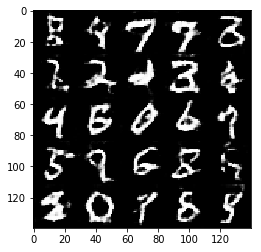

Epoch 2/2... batch: 470 Discriminator Loss: 0.6893... Generator Loss: 1.4995
Epoch 2/2... batch: 475 Discriminator Loss: 0.7589... Generator Loss: 1.4489
Epoch 2/2... batch: 480 Discriminator Loss: 0.7525... Generator Loss: 1.5090
Epoch 2/2... batch: 485 Discriminator Loss: 0.7572... Generator Loss: 1.4658
Epoch 2/2... batch: 490 Discriminator Loss: 0.5481... Generator Loss: 2.1930
Epoch 2/2... batch: 495 Discriminator Loss: 0.5969... Generator Loss: 2.2361
Epoch 2/2... batch: 500 Discriminator Loss: 0.7948... Generator Loss: 1.7829
Epoch 2/2... batch: 505 Discriminator Loss: 0.9065... Generator Loss: 1.0853
Epoch 2/2... batch: 510 Discriminator Loss: 0.8346... Generator Loss: 1.1951
Epoch 2/2... batch: 515 Discriminator Loss: 0.8870... Generator Loss: 1.0435
Epoch 2/2... batch: 520 Discriminator Loss: 0.9751... Generator Loss: 1.0387
Epoch 2/2... batch: 525 Discriminator Loss: 0.9394... Generator Loss: 0.9765


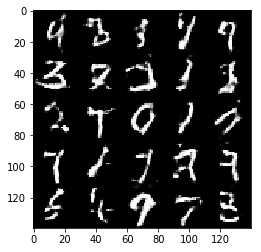

Epoch 2/2... batch: 530 Discriminator Loss: 0.8388... Generator Loss: 1.1563
Epoch 2/2... batch: 535 Discriminator Loss: 0.8092... Generator Loss: 1.2295
Epoch 2/2... batch: 540 Discriminator Loss: 0.6261... Generator Loss: 1.8882
Epoch 2/2... batch: 545 Discriminator Loss: 0.6063... Generator Loss: 1.9714
Epoch 2/2... batch: 550 Discriminator Loss: 1.5282... Generator Loss: 0.5141
Epoch 2/2... batch: 555 Discriminator Loss: 0.7648... Generator Loss: 1.4394
Epoch 2/2... batch: 560 Discriminator Loss: 0.8717... Generator Loss: 1.1720
Epoch 2/2... batch: 565 Discriminator Loss: 0.8059... Generator Loss: 1.2155
Epoch 2/2... batch: 570 Discriminator Loss: 1.1294... Generator Loss: 0.8068
Epoch 2/2... batch: 575 Discriminator Loss: 0.7679... Generator Loss: 1.2924
Epoch 2/2... batch: 580 Discriminator Loss: 0.8590... Generator Loss: 1.2130
Epoch 2/2... batch: 585 Discriminator Loss: 0.5752... Generator Loss: 2.0975


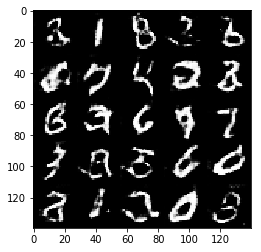

Epoch 2/2... batch: 590 Discriminator Loss: 0.5281... Generator Loss: 2.0857
Epoch 2/2... batch: 595 Discriminator Loss: 0.5822... Generator Loss: 1.8139
Epoch 2/2... batch: 600 Discriminator Loss: 0.6525... Generator Loss: 2.0170
Epoch 2/2... batch: 605 Discriminator Loss: 1.4506... Generator Loss: 0.5866
Epoch 2/2... batch: 610 Discriminator Loss: 0.6664... Generator Loss: 2.0499
Epoch 2/2... batch: 615 Discriminator Loss: 1.1863... Generator Loss: 1.1476
Epoch 2/2... batch: 620 Discriminator Loss: 0.6369... Generator Loss: 1.9459
Epoch 2/2... batch: 625 Discriminator Loss: 0.7117... Generator Loss: 1.3947
Epoch 2/2... batch: 630 Discriminator Loss: 0.5136... Generator Loss: 2.2876
Epoch 2/2... batch: 635 Discriminator Loss: 0.7823... Generator Loss: 1.4401
Epoch 2/2... batch: 640 Discriminator Loss: 0.8898... Generator Loss: 1.0577
Epoch 2/2... batch: 645 Discriminator Loss: 0.8682... Generator Loss: 1.0987


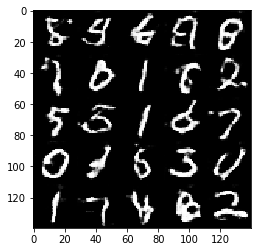

Epoch 2/2... batch: 650 Discriminator Loss: 0.6758... Generator Loss: 1.5920
Epoch 2/2... batch: 655 Discriminator Loss: 0.7391... Generator Loss: 1.5679
Epoch 2/2... batch: 660 Discriminator Loss: 0.7130... Generator Loss: 1.6187
Epoch 2/2... batch: 665 Discriminator Loss: 0.5695... Generator Loss: 1.8884
Epoch 2/2... batch: 670 Discriminator Loss: 0.7445... Generator Loss: 1.4898
Epoch 2/2... batch: 675 Discriminator Loss: 0.7073... Generator Loss: 1.4663
Epoch 2/2... batch: 680 Discriminator Loss: 0.5943... Generator Loss: 2.0020
Epoch 2/2... batch: 685 Discriminator Loss: 0.8039... Generator Loss: 1.1137
Epoch 2/2... batch: 690 Discriminator Loss: 1.1837... Generator Loss: 0.7679
Epoch 2/2... batch: 695 Discriminator Loss: 0.6827... Generator Loss: 1.8437
Epoch 2/2... batch: 700 Discriminator Loss: 0.8299... Generator Loss: 1.1086
Epoch 2/2... batch: 705 Discriminator Loss: 0.9363... Generator Loss: 1.0163


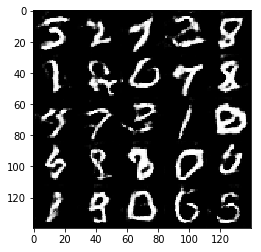

Epoch 2/2... batch: 710 Discriminator Loss: 0.8694... Generator Loss: 1.3728
Epoch 2/2... batch: 715 Discriminator Loss: 1.1031... Generator Loss: 1.0394
Epoch 2/2... batch: 720 Discriminator Loss: 0.7220... Generator Loss: 1.7243
Epoch 2/2... batch: 725 Discriminator Loss: 0.8128... Generator Loss: 1.6194
Epoch 2/2... batch: 730 Discriminator Loss: 0.8558... Generator Loss: 1.1619
Epoch 2/2... batch: 735 Discriminator Loss: 0.6158... Generator Loss: 1.6649
Epoch 2/2... batch: 740 Discriminator Loss: 0.5755... Generator Loss: 2.2874
Epoch 2/2... batch: 745 Discriminator Loss: 0.9101... Generator Loss: 1.0081
Epoch 2/2... batch: 750 Discriminator Loss: 1.6002... Generator Loss: 0.4560
Epoch 2/2... batch: 755 Discriminator Loss: 0.8227... Generator Loss: 1.5634
Epoch 2/2... batch: 760 Discriminator Loss: 0.6830... Generator Loss: 1.6659
Epoch 2/2... batch: 765 Discriminator Loss: 0.7127... Generator Loss: 1.5068


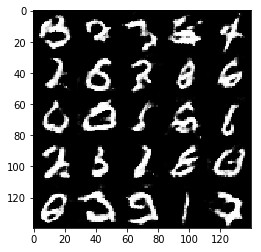

Epoch 2/2... batch: 770 Discriminator Loss: 0.8451... Generator Loss: 1.0852
Epoch 2/2... batch: 775 Discriminator Loss: 0.6501... Generator Loss: 1.7164
Epoch 2/2... batch: 780 Discriminator Loss: 0.6936... Generator Loss: 1.7693
Epoch 2/2... batch: 785 Discriminator Loss: 1.9939... Generator Loss: 0.3506
Epoch 2/2... batch: 790 Discriminator Loss: 0.7027... Generator Loss: 1.8327
Epoch 2/2... batch: 795 Discriminator Loss: 0.7541... Generator Loss: 2.4447
Epoch 2/2... batch: 800 Discriminator Loss: 0.7674... Generator Loss: 1.9798
Epoch 2/2... batch: 805 Discriminator Loss: 0.7922... Generator Loss: 1.2813
Epoch 2/2... batch: 810 Discriminator Loss: 0.6839... Generator Loss: 1.6137
Epoch 2/2... batch: 815 Discriminator Loss: 0.7554... Generator Loss: 2.1973
Epoch 2/2... batch: 820 Discriminator Loss: 1.4539... Generator Loss: 0.5482
Epoch 2/2... batch: 825 Discriminator Loss: 1.0697... Generator Loss: 0.8714


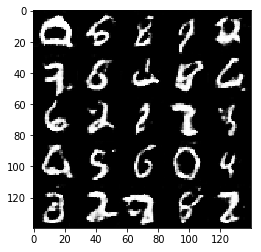

Epoch 2/2... batch: 830 Discriminator Loss: 0.8115... Generator Loss: 1.5690
Epoch 2/2... batch: 835 Discriminator Loss: 0.7377... Generator Loss: 1.4881
Epoch 2/2... batch: 840 Discriminator Loss: 1.1445... Generator Loss: 0.9234
Epoch 2/2... batch: 845 Discriminator Loss: 0.6600... Generator Loss: 1.6166
Epoch 2/2... batch: 850 Discriminator Loss: 1.3246... Generator Loss: 0.5956
Epoch 2/2... batch: 855 Discriminator Loss: 0.6258... Generator Loss: 1.9695
Epoch 2/2... batch: 860 Discriminator Loss: 0.5033... Generator Loss: 2.8957
Epoch 2/2... batch: 865 Discriminator Loss: 0.5591... Generator Loss: 2.0606
Epoch 2/2... batch: 870 Discriminator Loss: 0.8791... Generator Loss: 1.1366
Epoch 2/2... batch: 875 Discriminator Loss: 2.2615... Generator Loss: 0.3495
Epoch 2/2... batch: 880 Discriminator Loss: 0.8739... Generator Loss: 1.3944
Epoch 2/2... batch: 885 Discriminator Loss: 2.0025... Generator Loss: 0.3434


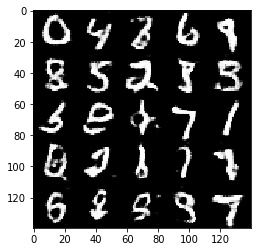

Epoch 2/2... batch: 890 Discriminator Loss: 0.6315... Generator Loss: 2.7142
Epoch 2/2... batch: 895 Discriminator Loss: 1.2387... Generator Loss: 0.7190
Epoch 2/2... batch: 900 Discriminator Loss: 0.6129... Generator Loss: 1.9181
Epoch 2/2... batch: 905 Discriminator Loss: 0.7772... Generator Loss: 1.4183
Epoch 2/2... batch: 910 Discriminator Loss: 0.6688... Generator Loss: 1.9636
Epoch 2/2... batch: 915 Discriminator Loss: 1.3006... Generator Loss: 0.6258
Epoch 2/2... batch: 920 Discriminator Loss: 0.8346... Generator Loss: 1.1253
Epoch 2/2... batch: 925 Discriminator Loss: 0.9633... Generator Loss: 2.5436
Epoch 2/2... batch: 930 Discriminator Loss: 0.7610... Generator Loss: 1.2974
Epoch 2/2... batch: 935 Discriminator Loss: 0.7493... Generator Loss: 1.3344
Epoch 2/2... batch: 940 Discriminator Loss: 1.5394... Generator Loss: 0.5619
Epoch 2/2... batch: 945 Discriminator Loss: 1.0625... Generator Loss: 0.9326


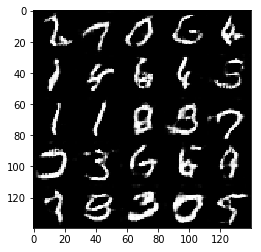

Epoch 2/2... batch: 950 Discriminator Loss: 0.7326... Generator Loss: 1.9087
Epoch 2/2... batch: 955 Discriminator Loss: 1.1055... Generator Loss: 0.7698
Epoch 2/2... batch: 960 Discriminator Loss: 0.6790... Generator Loss: 1.5643
Epoch 2/2... batch: 965 Discriminator Loss: 0.7502... Generator Loss: 1.9243
Epoch 2/2... batch: 970 Discriminator Loss: 0.9933... Generator Loss: 1.0087
Epoch 2/2... batch: 975 Discriminator Loss: 0.7087... Generator Loss: 1.4115
Epoch 2/2... batch: 980 Discriminator Loss: 0.8878... Generator Loss: 0.9854
Epoch 2/2... batch: 985 Discriminator Loss: 0.9565... Generator Loss: 1.0459
Epoch 2/2... batch: 990 Discriminator Loss: 0.9246... Generator Loss: 0.9325
Epoch 2/2... batch: 995 Discriminator Loss: 0.7368... Generator Loss: 1.2963
Epoch 2/2... batch: 1000 Discriminator Loss: 0.8861... Generator Loss: 1.0945
Epoch 2/2... batch: 1005 Discriminator Loss: 0.8239... Generator Loss: 1.1659


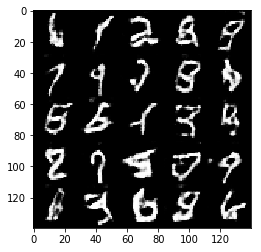

Epoch 2/2... batch: 1010 Discriminator Loss: 0.8685... Generator Loss: 1.2516
Epoch 2/2... batch: 1015 Discriminator Loss: 0.8370... Generator Loss: 1.3451
Epoch 2/2... batch: 1020 Discriminator Loss: 0.6520... Generator Loss: 1.6312
Epoch 2/2... batch: 1025 Discriminator Loss: 0.8018... Generator Loss: 1.1254
Epoch 2/2... batch: 1030 Discriminator Loss: 0.9485... Generator Loss: 1.0308
Epoch 2/2... batch: 1035 Discriminator Loss: 0.6388... Generator Loss: 1.8282
Epoch 2/2... batch: 1040 Discriminator Loss: 0.5370... Generator Loss: 2.2047
Epoch 2/2... batch: 1045 Discriminator Loss: 0.6419... Generator Loss: 1.7781
Epoch 2/2... batch: 1050 Discriminator Loss: 0.5869... Generator Loss: 2.5669
Epoch 2/2... batch: 1055 Discriminator Loss: 0.9160... Generator Loss: 1.0137
Epoch 2/2... batch: 1060 Discriminator Loss: 0.6356... Generator Loss: 1.6729
Epoch 2/2... batch: 1065 Discriminator Loss: 0.9612... Generator Loss: 1.0919


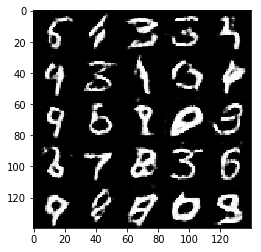

Epoch 2/2... batch: 1070 Discriminator Loss: 0.7992... Generator Loss: 1.2451
Epoch 2/2... batch: 1075 Discriminator Loss: 1.1460... Generator Loss: 0.7896
Epoch 2/2... batch: 1080 Discriminator Loss: 0.7212... Generator Loss: 1.4589
Epoch 2/2... batch: 1085 Discriminator Loss: 1.1065... Generator Loss: 0.8748
Epoch 2/2... batch: 1090 Discriminator Loss: 0.8741... Generator Loss: 2.4989
Epoch 2/2... batch: 1095 Discriminator Loss: 0.7144... Generator Loss: 1.3664
Epoch 2/2... batch: 1100 Discriminator Loss: 0.8027... Generator Loss: 1.1993
Epoch 2/2... batch: 1105 Discriminator Loss: 0.8923... Generator Loss: 1.0715
Epoch 2/2... batch: 1110 Discriminator Loss: 0.6000... Generator Loss: 1.9695
Epoch 2/2... batch: 1115 Discriminator Loss: 0.4767... Generator Loss: 2.2179
Epoch 2/2... batch: 1120 Discriminator Loss: 0.7972... Generator Loss: 1.2472
Epoch 2/2... batch: 1125 Discriminator Loss: 0.6619... Generator Loss: 1.7042


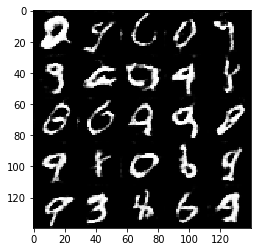

Epoch 2/2... batch: 1130 Discriminator Loss: 1.1339... Generator Loss: 0.7662
Epoch 2/2... batch: 1135 Discriminator Loss: 0.8977... Generator Loss: 3.2633
Epoch 2/2... batch: 1140 Discriminator Loss: 0.7983... Generator Loss: 3.4185
Epoch 2/2... batch: 1145 Discriminator Loss: 0.6955... Generator Loss: 1.6640
Epoch 2/2... batch: 1150 Discriminator Loss: 0.7635... Generator Loss: 1.2447
Epoch 2/2... batch: 1155 Discriminator Loss: 0.6541... Generator Loss: 2.1286
Epoch 2/2... batch: 1160 Discriminator Loss: 0.6353... Generator Loss: 2.2133
Epoch 2/2... batch: 1165 Discriminator Loss: 2.1724... Generator Loss: 0.2992
Epoch 2/2... batch: 1170 Discriminator Loss: 0.8243... Generator Loss: 2.5446
Epoch 2/2... batch: 1175 Discriminator Loss: 1.0761... Generator Loss: 0.9492
Epoch 2/2... batch: 1180 Discriminator Loss: 1.1636... Generator Loss: 0.7946
Epoch 2/2... batch: 1185 Discriminator Loss: 0.5729... Generator Loss: 2.0866


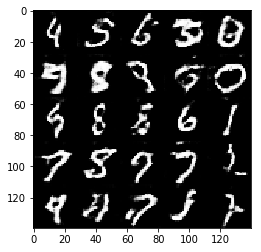

Epoch 2/2... batch: 1190 Discriminator Loss: 0.8388... Generator Loss: 1.2334
Epoch 2/2... batch: 1195 Discriminator Loss: 0.9185... Generator Loss: 0.9612
Epoch 2/2... batch: 1200 Discriminator Loss: 0.8665... Generator Loss: 1.0580
Epoch 2/2... batch: 1205 Discriminator Loss: 0.9949... Generator Loss: 0.9667
Epoch 2/2... batch: 1210 Discriminator Loss: 0.8029... Generator Loss: 1.4902
Epoch 2/2... batch: 1215 Discriminator Loss: 0.7609... Generator Loss: 1.2924
Epoch 2/2... batch: 1220 Discriminator Loss: 0.8072... Generator Loss: 1.2162
Epoch 2/2... batch: 1225 Discriminator Loss: 1.1824... Generator Loss: 0.8001
Epoch 2/2... batch: 1230 Discriminator Loss: 0.7048... Generator Loss: 1.5315
Epoch 2/2... batch: 1235 Discriminator Loss: 0.7547... Generator Loss: 1.3790
Epoch 2/2... batch: 1240 Discriminator Loss: 0.9436... Generator Loss: 1.0371
Epoch 2/2... batch: 1245 Discriminator Loss: 1.2874... Generator Loss: 0.7303


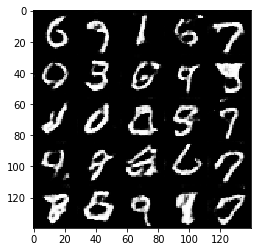

Epoch 2/2... batch: 1250 Discriminator Loss: 0.8544... Generator Loss: 1.1228
Epoch 2/2... batch: 1255 Discriminator Loss: 0.6391... Generator Loss: 1.7712
Epoch 2/2... batch: 1260 Discriminator Loss: 0.7780... Generator Loss: 1.3056
Epoch 2/2... batch: 1265 Discriminator Loss: 0.8725... Generator Loss: 1.0897
Epoch 2/2... batch: 1270 Discriminator Loss: 0.6293... Generator Loss: 1.9739
Epoch 2/2... batch: 1275 Discriminator Loss: 0.6733... Generator Loss: 1.5232
Epoch 2/2... batch: 1280 Discriminator Loss: 0.6458... Generator Loss: 1.7074
Epoch 2/2... batch: 1285 Discriminator Loss: 1.4065... Generator Loss: 0.5742
Epoch 2/2... batch: 1290 Discriminator Loss: 0.8795... Generator Loss: 1.2072
Epoch 2/2... batch: 1295 Discriminator Loss: 0.5623... Generator Loss: 2.3086
Epoch 2/2... batch: 1300 Discriminator Loss: 0.6223... Generator Loss: 1.9460
Epoch 2/2... batch: 1305 Discriminator Loss: 1.0986... Generator Loss: 0.7515


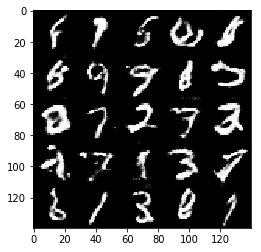

Epoch 2/2... batch: 1310 Discriminator Loss: 1.1010... Generator Loss: 0.8034
Epoch 2/2... batch: 1315 Discriminator Loss: 1.1581... Generator Loss: 0.7282
Epoch 2/2... batch: 1320 Discriminator Loss: 0.7410... Generator Loss: 1.4368
Epoch 2/2... batch: 1325 Discriminator Loss: 0.7036... Generator Loss: 1.7564
Epoch 2/2... batch: 1330 Discriminator Loss: 0.6349... Generator Loss: 1.6945
Epoch 2/2... batch: 1335 Discriminator Loss: 2.2888... Generator Loss: 3.4064
Epoch 2/2... batch: 1340 Discriminator Loss: 1.3644... Generator Loss: 0.8228
Epoch 2/2... batch: 1345 Discriminator Loss: 1.0039... Generator Loss: 1.0518
Epoch 2/2... batch: 1350 Discriminator Loss: 0.7039... Generator Loss: 1.7519
Epoch 2/2... batch: 1355 Discriminator Loss: 0.9565... Generator Loss: 1.1404
Epoch 2/2... batch: 1360 Discriminator Loss: 0.6810... Generator Loss: 1.5513
Epoch 2/2... batch: 1365 Discriminator Loss: 0.6325... Generator Loss: 1.7943


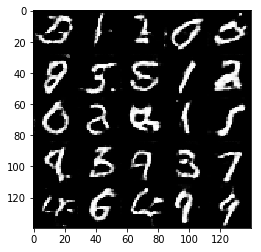

Epoch 2/2... batch: 1370 Discriminator Loss: 0.7293... Generator Loss: 1.4406
Epoch 2/2... batch: 1375 Discriminator Loss: 0.6954... Generator Loss: 1.4231
Epoch 2/2... batch: 1380 Discriminator Loss: 0.5772... Generator Loss: 2.2919
Epoch 2/2... batch: 1385 Discriminator Loss: 0.6914... Generator Loss: 1.7853
Epoch 2/2... batch: 1390 Discriminator Loss: 1.2589... Generator Loss: 0.7032
Epoch 2/2... batch: 1395 Discriminator Loss: 1.0193... Generator Loss: 0.9394
Epoch 2/2... batch: 1400 Discriminator Loss: 0.6832... Generator Loss: 1.5528
Epoch 2/2... batch: 1405 Discriminator Loss: 0.7378... Generator Loss: 1.6500
Epoch 2/2... batch: 1410 Discriminator Loss: 1.0346... Generator Loss: 1.0281
Epoch 2/2... batch: 1415 Discriminator Loss: 0.9572... Generator Loss: 0.9528
Epoch 2/2... batch: 1420 Discriminator Loss: 0.5683... Generator Loss: 2.3798
Epoch 2/2... batch: 1425 Discriminator Loss: 0.8594... Generator Loss: 1.1622


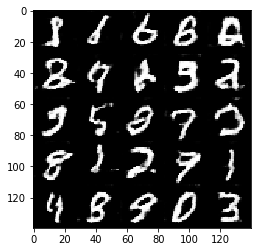

Epoch 2/2... batch: 1430 Discriminator Loss: 0.6708... Generator Loss: 1.7705
Epoch 2/2... batch: 1435 Discriminator Loss: 0.9229... Generator Loss: 1.1428
Epoch 2/2... batch: 1440 Discriminator Loss: 0.8927... Generator Loss: 1.3094
Epoch 2/2... batch: 1445 Discriminator Loss: 0.7258... Generator Loss: 3.2257
Epoch 2/2... batch: 1450 Discriminator Loss: 1.4576... Generator Loss: 3.9489
Epoch 2/2... batch: 1455 Discriminator Loss: 0.7940... Generator Loss: 1.5053
Epoch 2/2... batch: 1460 Discriminator Loss: 0.6651... Generator Loss: 1.7555
Epoch 2/2... batch: 1465 Discriminator Loss: 0.6630... Generator Loss: 1.8098
Epoch 2/2... batch: 1470 Discriminator Loss: 0.7532... Generator Loss: 1.4050
Epoch 2/2... batch: 1475 Discriminator Loss: 0.7921... Generator Loss: 1.1427
Epoch 2/2... batch: 1480 Discriminator Loss: 0.7513... Generator Loss: 1.9914
Epoch 2/2... batch: 1485 Discriminator Loss: 0.6472... Generator Loss: 2.0494


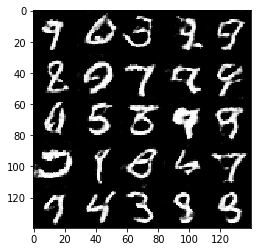

Epoch 2/2... batch: 1490 Discriminator Loss: 0.7248... Generator Loss: 1.4237
Epoch 2/2... batch: 1495 Discriminator Loss: 0.9103... Generator Loss: 1.0290
Epoch 2/2... batch: 1500 Discriminator Loss: 0.6100... Generator Loss: 2.3223
Epoch 2/2... batch: 1505 Discriminator Loss: 0.8012... Generator Loss: 1.2057
Epoch 2/2... batch: 1510 Discriminator Loss: 1.3973... Generator Loss: 0.5787
Epoch 2/2... batch: 1515 Discriminator Loss: 0.6033... Generator Loss: 1.8938
Epoch 2/2... batch: 1520 Discriminator Loss: 0.7216... Generator Loss: 1.4218
Epoch 2/2... batch: 1525 Discriminator Loss: 0.9245... Generator Loss: 1.0052
Epoch 2/2... batch: 1530 Discriminator Loss: 1.3693... Generator Loss: 0.6870
Epoch 2/2... batch: 1535 Discriminator Loss: 2.5480... Generator Loss: 0.3107
Epoch 2/2... batch: 1540 Discriminator Loss: 1.1026... Generator Loss: 0.8082
Epoch 2/2... batch: 1545 Discriminator Loss: 0.5832... Generator Loss: 2.1740


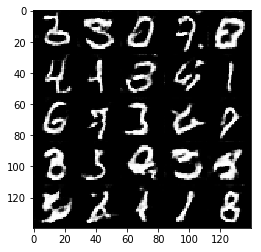

Epoch 2/2... batch: 1550 Discriminator Loss: 0.6415... Generator Loss: 1.9829
Epoch 2/2... batch: 1555 Discriminator Loss: 0.7078... Generator Loss: 1.8250
Epoch 2/2... batch: 1560 Discriminator Loss: 1.0494... Generator Loss: 0.8866
Epoch 2/2... batch: 1565 Discriminator Loss: 0.8423... Generator Loss: 1.3031
Epoch 2/2... batch: 1570 Discriminator Loss: 0.7148... Generator Loss: 1.4066
Epoch 2/2... batch: 1575 Discriminator Loss: 1.3081... Generator Loss: 0.6531
Epoch 2/2... batch: 1580 Discriminator Loss: 0.9563... Generator Loss: 0.9532
Epoch 2/2... batch: 1585 Discriminator Loss: 0.6419... Generator Loss: 1.7845
Epoch 2/2... batch: 1590 Discriminator Loss: 0.6839... Generator Loss: 1.3773
Epoch 2/2... batch: 1595 Discriminator Loss: 0.6557... Generator Loss: 1.6295
Epoch 2/2... batch: 1600 Discriminator Loss: 0.8182... Generator Loss: 1.1709
Epoch 2/2... batch: 1605 Discriminator Loss: 0.6870... Generator Loss: 1.5199


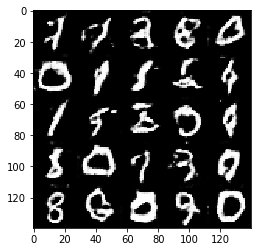

Epoch 2/2... batch: 1610 Discriminator Loss: 0.6150... Generator Loss: 2.0114
Epoch 2/2... batch: 1615 Discriminator Loss: 0.6614... Generator Loss: 1.7820
Epoch 2/2... batch: 1620 Discriminator Loss: 0.6258... Generator Loss: 1.9972
Epoch 2/2... batch: 1625 Discriminator Loss: 0.8100... Generator Loss: 1.3365
Epoch 2/2... batch: 1630 Discriminator Loss: 0.8308... Generator Loss: 1.2831
Epoch 2/2... batch: 1635 Discriminator Loss: 0.6573... Generator Loss: 1.7440
Epoch 2/2... batch: 1640 Discriminator Loss: 0.8826... Generator Loss: 1.0830
Epoch 2/2... batch: 1645 Discriminator Loss: 0.6227... Generator Loss: 1.8621
Epoch 2/2... batch: 1650 Discriminator Loss: 0.5375... Generator Loss: 1.9561
Epoch 2/2... batch: 1655 Discriminator Loss: 1.4283... Generator Loss: 0.5694
Epoch 2/2... batch: 1660 Discriminator Loss: 0.7918... Generator Loss: 1.3426
Epoch 2/2... batch: 1665 Discriminator Loss: 0.6619... Generator Loss: 1.8274


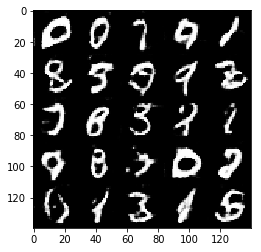

Epoch 2/2... batch: 1670 Discriminator Loss: 0.5762... Generator Loss: 2.0308
Epoch 2/2... batch: 1675 Discriminator Loss: 0.6319... Generator Loss: 2.0059
Epoch 2/2... batch: 1680 Discriminator Loss: 0.8434... Generator Loss: 1.2789
Epoch 2/2... batch: 1685 Discriminator Loss: 0.8224... Generator Loss: 1.1104
Epoch 2/2... batch: 1690 Discriminator Loss: 0.8036... Generator Loss: 1.3008
Epoch 2/2... batch: 1695 Discriminator Loss: 0.6286... Generator Loss: 1.6880
Epoch 2/2... batch: 1700 Discriminator Loss: 1.2004... Generator Loss: 0.6679
Epoch 2/2... batch: 1705 Discriminator Loss: 0.8038... Generator Loss: 1.2678
Epoch 2/2... batch: 1710 Discriminator Loss: 0.6349... Generator Loss: 2.2994
Epoch 2/2... batch: 1715 Discriminator Loss: 0.8630... Generator Loss: 1.1996
Epoch 2/2... batch: 1720 Discriminator Loss: 0.6974... Generator Loss: 1.3317
Epoch 2/2... batch: 1725 Discriminator Loss: 1.3825... Generator Loss: 0.6106


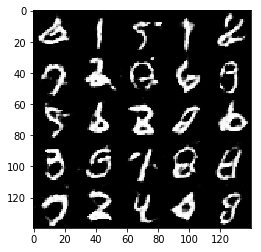

Epoch 2/2... batch: 1730 Discriminator Loss: 0.8577... Generator Loss: 1.1384
Epoch 2/2... batch: 1735 Discriminator Loss: 1.0302... Generator Loss: 0.8862
Epoch 2/2... batch: 1740 Discriminator Loss: 0.7471... Generator Loss: 1.3627
Epoch 2/2... batch: 1745 Discriminator Loss: 0.5913... Generator Loss: 2.2817
Epoch 2/2... batch: 1750 Discriminator Loss: 0.5543... Generator Loss: 2.7022
Epoch 2/2... batch: 1755 Discriminator Loss: 1.2983... Generator Loss: 0.7722
Epoch 2/2... batch: 1760 Discriminator Loss: 0.7042... Generator Loss: 3.0278
Epoch 2/2... batch: 1765 Discriminator Loss: 1.9312... Generator Loss: 0.3427
Epoch 2/2... batch: 1770 Discriminator Loss: 0.7562... Generator Loss: 2.3314
Epoch 2/2... batch: 1775 Discriminator Loss: 0.6695... Generator Loss: 1.7017
Epoch 2/2... batch: 1780 Discriminator Loss: 0.5207... Generator Loss: 2.1403
Epoch 2/2... batch: 1785 Discriminator Loss: 0.7406... Generator Loss: 1.4964


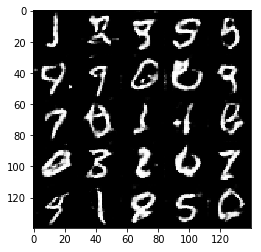

Epoch 2/2... batch: 1790 Discriminator Loss: 0.9317... Generator Loss: 0.9900
Epoch 2/2... batch: 1795 Discriminator Loss: 0.6229... Generator Loss: 1.8754
Epoch 2/2... batch: 1800 Discriminator Loss: 0.7747... Generator Loss: 1.3414
Epoch 2/2... batch: 1805 Discriminator Loss: 0.6671... Generator Loss: 2.1011
Epoch 2/2... batch: 1810 Discriminator Loss: 0.5580... Generator Loss: 2.3334
Epoch 2/2... batch: 1815 Discriminator Loss: 1.1452... Generator Loss: 0.8377
Epoch 2/2... batch: 1820 Discriminator Loss: 0.6296... Generator Loss: 2.1679
Epoch 2/2... batch: 1825 Discriminator Loss: 0.7268... Generator Loss: 1.4120
Epoch 2/2... batch: 1830 Discriminator Loss: 2.1820... Generator Loss: 0.3373
Epoch 2/2... batch: 1835 Discriminator Loss: 1.0508... Generator Loss: 1.1247
Epoch 2/2... batch: 1840 Discriminator Loss: 0.7023... Generator Loss: 2.2752
Epoch 2/2... batch: 1845 Discriminator Loss: 0.9058... Generator Loss: 1.4130


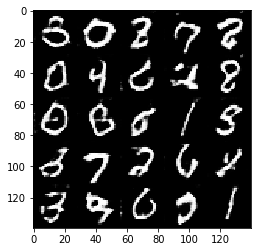

Epoch 2/2... batch: 1850 Discriminator Loss: 0.9108... Generator Loss: 1.1244
Epoch 2/2... batch: 1855 Discriminator Loss: 0.9539... Generator Loss: 1.2793
Epoch 2/2... batch: 1860 Discriminator Loss: 2.1420... Generator Loss: 0.3756
Epoch 2/2... batch: 1865 Discriminator Loss: 0.6180... Generator Loss: 1.8300
Epoch 2/2... batch: 1870 Discriminator Loss: 1.1460... Generator Loss: 0.9236
Epoch 2/2... batch: 1875 Discriminator Loss: 0.4695... Generator Loss: 3.0158


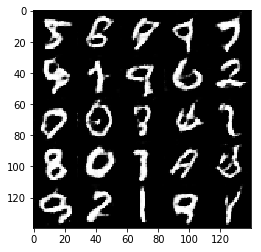

In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape, mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

batch size: 64
Epoch 1/1... batch: 5 Discriminator Loss: 0.9518... Generator Loss: 1.8306
Epoch 1/1... batch: 10 Discriminator Loss: 0.5666... Generator Loss: 5.3313
Epoch 1/1... batch: 15 Discriminator Loss: 0.6581... Generator Loss: 2.8128
Epoch 1/1... batch: 20 Discriminator Loss: 0.6063... Generator Loss: 3.4446
Epoch 1/1... batch: 25 Discriminator Loss: 0.6176... Generator Loss: 2.7100
Epoch 1/1... batch: 30 Discriminator Loss: 1.1910... Generator Loss: 8.9581
Epoch 1/1... batch: 35 Discriminator Loss: 2.0565... Generator Loss: 0.4288
Epoch 1/1... batch: 40 Discriminator Loss: 0.9838... Generator Loss: 1.3043
Epoch 1/1... batch: 45 Discriminator Loss: 2.1031... Generator Loss: 0.2704
Epoch 1/1... batch: 50 Discriminator Loss: 1.4917... Generator Loss: 0.5451
Epoch 1/1... batch: 55 Discriminator Loss: 1.0438... Generator Loss: 2.1437
Epoch 1/1... batch: 60 Discriminator Loss: 2.0035... Generator Loss: 3.8655


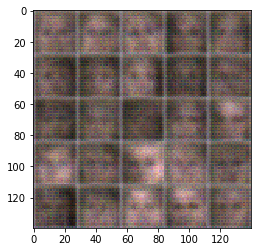

Epoch 1/1... batch: 65 Discriminator Loss: 1.2377... Generator Loss: 1.1939
Epoch 1/1... batch: 70 Discriminator Loss: 2.0994... Generator Loss: 0.2557
Epoch 1/1... batch: 75 Discriminator Loss: 1.1834... Generator Loss: 0.7518
Epoch 1/1... batch: 80 Discriminator Loss: 1.3089... Generator Loss: 0.6815
Epoch 1/1... batch: 85 Discriminator Loss: 1.0920... Generator Loss: 2.5421
Epoch 1/1... batch: 90 Discriminator Loss: 1.1718... Generator Loss: 1.8184
Epoch 1/1... batch: 95 Discriminator Loss: 1.1726... Generator Loss: 0.7788
Epoch 1/1... batch: 100 Discriminator Loss: 1.1098... Generator Loss: 1.0625
Epoch 1/1... batch: 105 Discriminator Loss: 1.1570... Generator Loss: 0.8403
Epoch 1/1... batch: 110 Discriminator Loss: 1.0310... Generator Loss: 1.3649
Epoch 1/1... batch: 115 Discriminator Loss: 1.2426... Generator Loss: 2.5390
Epoch 1/1... batch: 120 Discriminator Loss: 1.4904... Generator Loss: 0.5604


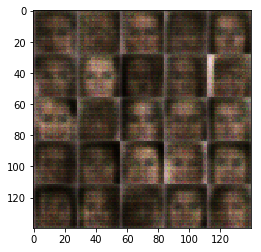

Epoch 1/1... batch: 125 Discriminator Loss: 0.9543... Generator Loss: 1.1374
Epoch 1/1... batch: 130 Discriminator Loss: 1.0699... Generator Loss: 1.0316
Epoch 1/1... batch: 135 Discriminator Loss: 1.8994... Generator Loss: 0.3646
Epoch 1/1... batch: 140 Discriminator Loss: 1.1997... Generator Loss: 0.8597
Epoch 1/1... batch: 145 Discriminator Loss: 1.2932... Generator Loss: 1.8977
Epoch 1/1... batch: 150 Discriminator Loss: 0.9508... Generator Loss: 1.2659
Epoch 1/1... batch: 155 Discriminator Loss: 2.0217... Generator Loss: 0.3366
Epoch 1/1... batch: 160 Discriminator Loss: 1.3605... Generator Loss: 0.5964
Epoch 1/1... batch: 165 Discriminator Loss: 1.3393... Generator Loss: 0.6655
Epoch 1/1... batch: 170 Discriminator Loss: 1.0908... Generator Loss: 1.1382
Epoch 1/1... batch: 175 Discriminator Loss: 1.0166... Generator Loss: 1.1014
Epoch 1/1... batch: 180 Discriminator Loss: 1.1448... Generator Loss: 0.7960


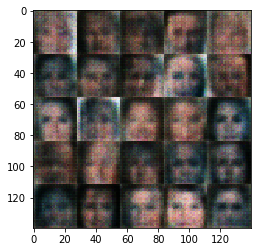

Epoch 1/1... batch: 185 Discriminator Loss: 1.8004... Generator Loss: 0.3892
Epoch 1/1... batch: 190 Discriminator Loss: 1.2016... Generator Loss: 0.8227
Epoch 1/1... batch: 195 Discriminator Loss: 1.1331... Generator Loss: 1.4817
Epoch 1/1... batch: 200 Discriminator Loss: 0.9722... Generator Loss: 1.2251
Epoch 1/1... batch: 205 Discriminator Loss: 0.8636... Generator Loss: 2.1132
Epoch 1/1... batch: 210 Discriminator Loss: 1.0120... Generator Loss: 1.4000
Epoch 1/1... batch: 215 Discriminator Loss: 1.0299... Generator Loss: 0.9137
Epoch 1/1... batch: 220 Discriminator Loss: 0.9207... Generator Loss: 2.5047
Epoch 1/1... batch: 225 Discriminator Loss: 0.7349... Generator Loss: 1.6519
Epoch 1/1... batch: 230 Discriminator Loss: 0.7037... Generator Loss: 1.5197
Epoch 1/1... batch: 235 Discriminator Loss: 1.3270... Generator Loss: 0.5665
Epoch 1/1... batch: 240 Discriminator Loss: 1.1945... Generator Loss: 0.7052


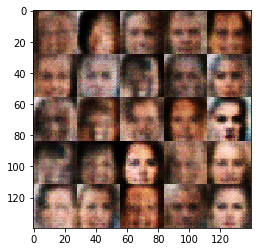

Epoch 1/1... batch: 245 Discriminator Loss: 1.1342... Generator Loss: 1.1356
Epoch 1/1... batch: 250 Discriminator Loss: 1.0900... Generator Loss: 0.8513
Epoch 1/1... batch: 255 Discriminator Loss: 1.1458... Generator Loss: 1.0604
Epoch 1/1... batch: 260 Discriminator Loss: 1.0266... Generator Loss: 1.4887
Epoch 1/1... batch: 265 Discriminator Loss: 0.9662... Generator Loss: 1.3703
Epoch 1/1... batch: 270 Discriminator Loss: 0.9196... Generator Loss: 1.3086
Epoch 1/1... batch: 275 Discriminator Loss: 0.9514... Generator Loss: 1.1495
Epoch 1/1... batch: 280 Discriminator Loss: 0.9538... Generator Loss: 1.0489
Epoch 1/1... batch: 285 Discriminator Loss: 1.2665... Generator Loss: 1.1163
Epoch 1/1... batch: 290 Discriminator Loss: 1.1642... Generator Loss: 0.6609
Epoch 1/1... batch: 295 Discriminator Loss: 1.2444... Generator Loss: 0.9465
Epoch 1/1... batch: 300 Discriminator Loss: 1.0466... Generator Loss: 0.9530


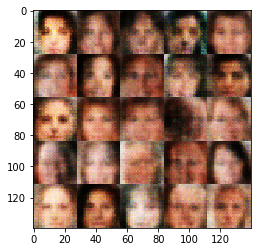

Epoch 1/1... batch: 305 Discriminator Loss: 1.0995... Generator Loss: 0.8722
Epoch 1/1... batch: 310 Discriminator Loss: 0.7692... Generator Loss: 1.5426
Epoch 1/1... batch: 315 Discriminator Loss: 0.7374... Generator Loss: 2.4960
Epoch 1/1... batch: 320 Discriminator Loss: 1.0066... Generator Loss: 1.5599
Epoch 1/1... batch: 325 Discriminator Loss: 1.0066... Generator Loss: 1.1343
Epoch 1/1... batch: 330 Discriminator Loss: 0.9605... Generator Loss: 1.0680
Epoch 1/1... batch: 335 Discriminator Loss: 1.5219... Generator Loss: 0.4962
Epoch 1/1... batch: 340 Discriminator Loss: 1.3423... Generator Loss: 0.5520
Epoch 1/1... batch: 345 Discriminator Loss: 1.0790... Generator Loss: 1.0579
Epoch 1/1... batch: 350 Discriminator Loss: 1.1694... Generator Loss: 0.7601
Epoch 1/1... batch: 355 Discriminator Loss: 1.1390... Generator Loss: 2.2530
Epoch 1/1... batch: 360 Discriminator Loss: 1.2044... Generator Loss: 1.3630


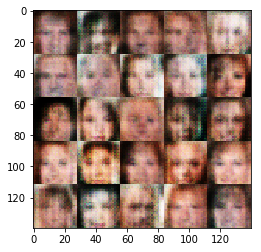

Epoch 1/1... batch: 365 Discriminator Loss: 1.4241... Generator Loss: 1.5400
Epoch 1/1... batch: 370 Discriminator Loss: 1.1818... Generator Loss: 1.5885
Epoch 1/1... batch: 375 Discriminator Loss: 0.9263... Generator Loss: 1.8287
Epoch 1/1... batch: 380 Discriminator Loss: 1.2952... Generator Loss: 0.6022
Epoch 1/1... batch: 385 Discriminator Loss: 1.6718... Generator Loss: 2.9921
Epoch 1/1... batch: 390 Discriminator Loss: 1.0643... Generator Loss: 0.8271
Epoch 1/1... batch: 395 Discriminator Loss: 1.4622... Generator Loss: 0.5883
Epoch 1/1... batch: 400 Discriminator Loss: 0.9097... Generator Loss: 1.2674
Epoch 1/1... batch: 405 Discriminator Loss: 1.5884... Generator Loss: 0.4389
Epoch 1/1... batch: 410 Discriminator Loss: 1.1706... Generator Loss: 1.0904
Epoch 1/1... batch: 415 Discriminator Loss: 1.2721... Generator Loss: 1.7418
Epoch 1/1... batch: 420 Discriminator Loss: 1.1926... Generator Loss: 1.8853


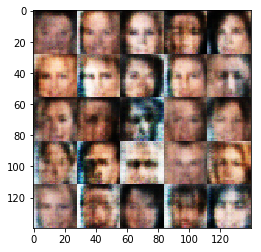

Epoch 1/1... batch: 425 Discriminator Loss: 0.9777... Generator Loss: 1.1894
Epoch 1/1... batch: 430 Discriminator Loss: 1.2170... Generator Loss: 0.7953
Epoch 1/1... batch: 435 Discriminator Loss: 1.1566... Generator Loss: 0.7833
Epoch 1/1... batch: 440 Discriminator Loss: 1.1044... Generator Loss: 1.0021
Epoch 1/1... batch: 445 Discriminator Loss: 1.3353... Generator Loss: 1.2538
Epoch 1/1... batch: 450 Discriminator Loss: 1.1924... Generator Loss: 1.4065
Epoch 1/1... batch: 455 Discriminator Loss: 1.1823... Generator Loss: 0.9229
Epoch 1/1... batch: 460 Discriminator Loss: 1.4107... Generator Loss: 0.6140
Epoch 1/1... batch: 465 Discriminator Loss: 1.1764... Generator Loss: 0.8026
Epoch 1/1... batch: 470 Discriminator Loss: 1.1924... Generator Loss: 1.0491
Epoch 1/1... batch: 475 Discriminator Loss: 1.2914... Generator Loss: 0.7908
Epoch 1/1... batch: 480 Discriminator Loss: 1.2135... Generator Loss: 1.4153


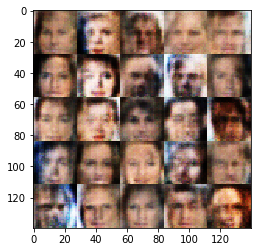

Epoch 1/1... batch: 485 Discriminator Loss: 1.1762... Generator Loss: 1.2314
Epoch 1/1... batch: 490 Discriminator Loss: 1.2083... Generator Loss: 1.0267
Epoch 1/1... batch: 495 Discriminator Loss: 1.0816... Generator Loss: 0.9089
Epoch 1/1... batch: 500 Discriminator Loss: 1.1554... Generator Loss: 1.0691
Epoch 1/1... batch: 505 Discriminator Loss: 1.1184... Generator Loss: 1.0075
Epoch 1/1... batch: 510 Discriminator Loss: 1.0558... Generator Loss: 1.2134
Epoch 1/1... batch: 515 Discriminator Loss: 0.9440... Generator Loss: 1.0454
Epoch 1/1... batch: 520 Discriminator Loss: 1.1042... Generator Loss: 1.1871
Epoch 1/1... batch: 525 Discriminator Loss: 0.9188... Generator Loss: 1.4667
Epoch 1/1... batch: 530 Discriminator Loss: 1.8425... Generator Loss: 3.2164
Epoch 1/1... batch: 535 Discriminator Loss: 1.1061... Generator Loss: 2.4438
Epoch 1/1... batch: 540 Discriminator Loss: 1.0150... Generator Loss: 1.2180


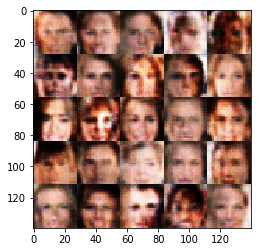

Epoch 1/1... batch: 545 Discriminator Loss: 1.4051... Generator Loss: 0.6168
Epoch 1/1... batch: 550 Discriminator Loss: 1.2348... Generator Loss: 0.8637
Epoch 1/1... batch: 555 Discriminator Loss: 1.0095... Generator Loss: 1.4765
Epoch 1/1... batch: 560 Discriminator Loss: 1.0708... Generator Loss: 1.8059
Epoch 1/1... batch: 565 Discriminator Loss: 0.7813... Generator Loss: 1.6731
Epoch 1/1... batch: 570 Discriminator Loss: 2.4177... Generator Loss: 0.2461
Epoch 1/1... batch: 575 Discriminator Loss: 1.1919... Generator Loss: 0.7536
Epoch 1/1... batch: 580 Discriminator Loss: 1.1751... Generator Loss: 0.9942
Epoch 1/1... batch: 585 Discriminator Loss: 1.1183... Generator Loss: 1.9483
Epoch 1/1... batch: 590 Discriminator Loss: 0.8575... Generator Loss: 1.5141
Epoch 1/1... batch: 595 Discriminator Loss: 0.9259... Generator Loss: 1.2883
Epoch 1/1... batch: 600 Discriminator Loss: 1.2398... Generator Loss: 1.8700


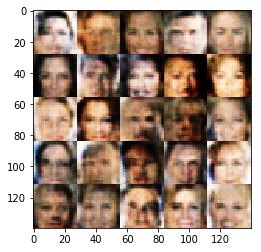

Epoch 1/1... batch: 605 Discriminator Loss: 1.8498... Generator Loss: 0.3497
Epoch 1/1... batch: 610 Discriminator Loss: 1.2511... Generator Loss: 0.8111
Epoch 1/1... batch: 615 Discriminator Loss: 1.0561... Generator Loss: 0.9643
Epoch 1/1... batch: 620 Discriminator Loss: 1.2422... Generator Loss: 0.7247
Epoch 1/1... batch: 625 Discriminator Loss: 1.0526... Generator Loss: 2.6856
Epoch 1/1... batch: 630 Discriminator Loss: 1.5536... Generator Loss: 0.4231
Epoch 1/1... batch: 635 Discriminator Loss: 0.9077... Generator Loss: 1.7535
Epoch 1/1... batch: 640 Discriminator Loss: 1.0788... Generator Loss: 0.8302
Epoch 1/1... batch: 645 Discriminator Loss: 1.7227... Generator Loss: 2.9386
Epoch 1/1... batch: 650 Discriminator Loss: 1.1455... Generator Loss: 0.8454
Epoch 1/1... batch: 655 Discriminator Loss: 0.7737... Generator Loss: 1.9095
Epoch 1/1... batch: 660 Discriminator Loss: 1.0407... Generator Loss: 2.5898


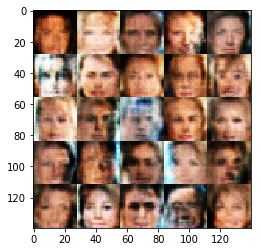

Epoch 1/1... batch: 665 Discriminator Loss: 0.7051... Generator Loss: 1.6550
Epoch 1/1... batch: 670 Discriminator Loss: 0.9094... Generator Loss: 2.5412
Epoch 1/1... batch: 675 Discriminator Loss: 1.3650... Generator Loss: 0.5593
Epoch 1/1... batch: 680 Discriminator Loss: 1.1251... Generator Loss: 1.2688
Epoch 1/1... batch: 685 Discriminator Loss: 0.7570... Generator Loss: 1.9117
Epoch 1/1... batch: 690 Discriminator Loss: 1.1110... Generator Loss: 0.7614
Epoch 1/1... batch: 695 Discriminator Loss: 2.0244... Generator Loss: 0.2608
Epoch 1/1... batch: 700 Discriminator Loss: 0.8382... Generator Loss: 2.1879
Epoch 1/1... batch: 705 Discriminator Loss: 1.0158... Generator Loss: 0.9164
Epoch 1/1... batch: 710 Discriminator Loss: 0.7353... Generator Loss: 4.0304
Epoch 1/1... batch: 715 Discriminator Loss: 0.7551... Generator Loss: 1.4039
Epoch 1/1... batch: 720 Discriminator Loss: 0.8286... Generator Loss: 1.1146


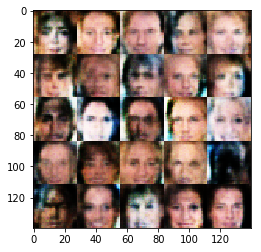

Epoch 1/1... batch: 725 Discriminator Loss: 0.8573... Generator Loss: 1.2249
Epoch 1/1... batch: 730 Discriminator Loss: 0.8995... Generator Loss: 1.1704
Epoch 1/1... batch: 735 Discriminator Loss: 0.9988... Generator Loss: 1.6540
Epoch 1/1... batch: 740 Discriminator Loss: 0.6439... Generator Loss: 4.6146
Epoch 1/1... batch: 745 Discriminator Loss: 0.6096... Generator Loss: 3.0949
Epoch 1/1... batch: 750 Discriminator Loss: 1.4737... Generator Loss: 0.4904
Epoch 1/1... batch: 755 Discriminator Loss: 0.8270... Generator Loss: 2.7292
Epoch 1/1... batch: 760 Discriminator Loss: 1.1490... Generator Loss: 0.6734
Epoch 1/1... batch: 765 Discriminator Loss: 1.2699... Generator Loss: 0.5911
Epoch 1/1... batch: 770 Discriminator Loss: 1.8700... Generator Loss: 3.4570
Epoch 1/1... batch: 775 Discriminator Loss: 0.5964... Generator Loss: 2.9069
Epoch 1/1... batch: 780 Discriminator Loss: 1.1027... Generator Loss: 0.8728


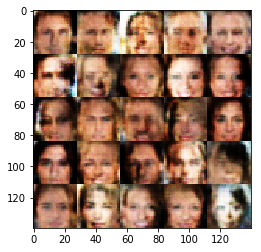

Epoch 1/1... batch: 785 Discriminator Loss: 1.1036... Generator Loss: 0.7832
Epoch 1/1... batch: 790 Discriminator Loss: 0.6405... Generator Loss: 2.2470
Epoch 1/1... batch: 795 Discriminator Loss: 1.5816... Generator Loss: 4.1931
Epoch 1/1... batch: 800 Discriminator Loss: 1.0450... Generator Loss: 0.8546
Epoch 1/1... batch: 805 Discriminator Loss: 0.6803... Generator Loss: 1.6288
Epoch 1/1... batch: 810 Discriminator Loss: 0.4941... Generator Loss: 2.8219
Epoch 1/1... batch: 815 Discriminator Loss: 0.7007... Generator Loss: 2.9307
Epoch 1/1... batch: 820 Discriminator Loss: 0.6864... Generator Loss: 1.4953
Epoch 1/1... batch: 825 Discriminator Loss: 1.6579... Generator Loss: 0.4677
Epoch 1/1... batch: 830 Discriminator Loss: 0.9954... Generator Loss: 1.7862
Epoch 1/1... batch: 835 Discriminator Loss: 0.6489... Generator Loss: 1.9038
Epoch 1/1... batch: 840 Discriminator Loss: 1.3819... Generator Loss: 5.7051


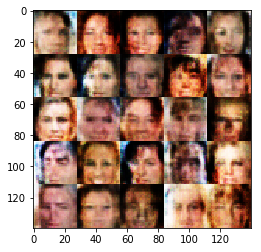

Epoch 1/1... batch: 845 Discriminator Loss: 0.6125... Generator Loss: 2.3246
Epoch 1/1... batch: 850 Discriminator Loss: 0.4985... Generator Loss: 3.0777
Epoch 1/1... batch: 855 Discriminator Loss: 0.6710... Generator Loss: 3.5852
Epoch 1/1... batch: 860 Discriminator Loss: 1.5468... Generator Loss: 0.4723
Epoch 1/1... batch: 865 Discriminator Loss: 0.7861... Generator Loss: 1.4181
Epoch 1/1... batch: 870 Discriminator Loss: 0.7427... Generator Loss: 5.1852
Epoch 1/1... batch: 875 Discriminator Loss: 1.0752... Generator Loss: 6.3840
Epoch 1/1... batch: 880 Discriminator Loss: 0.6238... Generator Loss: 1.6893
Epoch 1/1... batch: 885 Discriminator Loss: 1.1988... Generator Loss: 3.3311
Epoch 1/1... batch: 890 Discriminator Loss: 0.7295... Generator Loss: 1.7729
Epoch 1/1... batch: 895 Discriminator Loss: 1.3210... Generator Loss: 0.6148
Epoch 1/1... batch: 900 Discriminator Loss: 0.4938... Generator Loss: 3.3613


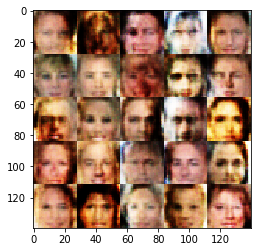

Epoch 1/1... batch: 905 Discriminator Loss: 0.4691... Generator Loss: 5.3629
Epoch 1/1... batch: 910 Discriminator Loss: 0.5357... Generator Loss: 2.3655
Epoch 1/1... batch: 915 Discriminator Loss: 0.7179... Generator Loss: 1.3693
Epoch 1/1... batch: 920 Discriminator Loss: 0.9721... Generator Loss: 0.9576
Epoch 1/1... batch: 925 Discriminator Loss: 0.5891... Generator Loss: 2.1104
Epoch 1/1... batch: 930 Discriminator Loss: 0.6346... Generator Loss: 1.8099
Epoch 1/1... batch: 935 Discriminator Loss: 0.4510... Generator Loss: 4.9583
Epoch 1/1... batch: 940 Discriminator Loss: 0.7506... Generator Loss: 4.6629
Epoch 1/1... batch: 945 Discriminator Loss: 0.4174... Generator Loss: 5.3858
Epoch 1/1... batch: 950 Discriminator Loss: 0.7238... Generator Loss: 1.4592
Epoch 1/1... batch: 955 Discriminator Loss: 0.5421... Generator Loss: 2.6492
Epoch 1/1... batch: 960 Discriminator Loss: 1.1877... Generator Loss: 0.6805


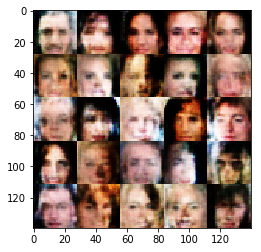

Epoch 1/1... batch: 965 Discriminator Loss: 0.6224... Generator Loss: 1.8376
Epoch 1/1... batch: 970 Discriminator Loss: 0.4409... Generator Loss: 2.9964
Epoch 1/1... batch: 975 Discriminator Loss: 0.4277... Generator Loss: 6.8237
Epoch 1/1... batch: 980 Discriminator Loss: 0.8466... Generator Loss: 6.1761
Epoch 1/1... batch: 985 Discriminator Loss: 0.5736... Generator Loss: 4.4263
Epoch 1/1... batch: 990 Discriminator Loss: 0.6955... Generator Loss: 1.4874
Epoch 1/1... batch: 995 Discriminator Loss: 0.5093... Generator Loss: 4.5221
Epoch 1/1... batch: 1000 Discriminator Loss: 0.8970... Generator Loss: 1.0390
Epoch 1/1... batch: 1005 Discriminator Loss: 0.4680... Generator Loss: 3.6726
Epoch 1/1... batch: 1010 Discriminator Loss: 0.7553... Generator Loss: 1.4963
Epoch 1/1... batch: 1015 Discriminator Loss: 0.9834... Generator Loss: 0.9054
Epoch 1/1... batch: 1020 Discriminator Loss: 0.7692... Generator Loss: 1.5519


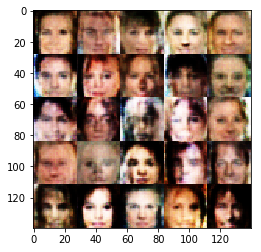

Epoch 1/1... batch: 1025 Discriminator Loss: 0.7256... Generator Loss: 1.5183
Epoch 1/1... batch: 1030 Discriminator Loss: 0.6485... Generator Loss: 1.8384
Epoch 1/1... batch: 1035 Discriminator Loss: 0.6060... Generator Loss: 6.8938
Epoch 1/1... batch: 1040 Discriminator Loss: 0.5152... Generator Loss: 2.8013
Epoch 1/1... batch: 1045 Discriminator Loss: 0.4279... Generator Loss: 4.0763
Epoch 1/1... batch: 1050 Discriminator Loss: 0.6324... Generator Loss: 1.7416
Epoch 1/1... batch: 1055 Discriminator Loss: 0.7679... Generator Loss: 1.3451
Epoch 1/1... batch: 1060 Discriminator Loss: 0.4654... Generator Loss: 3.8780
Epoch 1/1... batch: 1065 Discriminator Loss: 0.6716... Generator Loss: 1.5909
Epoch 1/1... batch: 1070 Discriminator Loss: 0.5307... Generator Loss: 5.0438
Epoch 1/1... batch: 1075 Discriminator Loss: 0.5351... Generator Loss: 2.6636
Epoch 1/1... batch: 1080 Discriminator Loss: 0.4314... Generator Loss: 6.4193


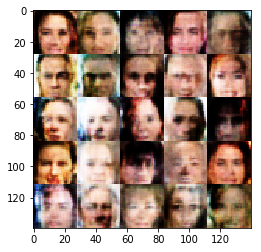

Epoch 1/1... batch: 1085 Discriminator Loss: 0.4963... Generator Loss: 3.7067
Epoch 1/1... batch: 1090 Discriminator Loss: 0.8731... Generator Loss: 1.1119
Epoch 1/1... batch: 1095 Discriminator Loss: 1.3646... Generator Loss: 3.6523
Epoch 1/1... batch: 1100 Discriminator Loss: 0.6644... Generator Loss: 2.0027
Epoch 1/1... batch: 1105 Discriminator Loss: 1.0780... Generator Loss: 5.2659
Epoch 1/1... batch: 1110 Discriminator Loss: 0.4794... Generator Loss: 5.7091
Epoch 1/1... batch: 1115 Discriminator Loss: 0.6160... Generator Loss: 1.8865
Epoch 1/1... batch: 1120 Discriminator Loss: 0.4053... Generator Loss: 5.8268
Epoch 1/1... batch: 1125 Discriminator Loss: 0.6291... Generator Loss: 1.9911
Epoch 1/1... batch: 1130 Discriminator Loss: 0.4712... Generator Loss: 3.6219
Epoch 1/1... batch: 1135 Discriminator Loss: 0.4851... Generator Loss: 3.2154
Epoch 1/1... batch: 1140 Discriminator Loss: 0.7273... Generator Loss: 1.5212


Epoch 1/1... batch: 1145 Discriminator Loss: 0.6155... Generator Loss: 6.3924
Epoch 1/1... batch: 1150 Discriminator Loss: 0.5151... Generator Loss: 2.8658
Epoch 1/1... batch: 1155 Discriminator Loss: 1.1866... Generator Loss: 0.7212
Epoch 1/1... batch: 1160 Discriminator Loss: 0.6760... Generator Loss: 1.4710
Epoch 1/1... batch: 1165 Discriminator Loss: 0.4401... Generator Loss: 3.8724
Epoch 1/1... batch: 1170 Discriminator Loss: 0.5415... Generator Loss: 4.2680
Epoch 1/1... batch: 1175 Discriminator Loss: 0.8695... Generator Loss: 1.0317
Epoch 1/1... batch: 1180 Discriminator Loss: 0.5715... Generator Loss: 3.9446
Epoch 1/1... batch: 1185 Discriminator Loss: 0.9451... Generator Loss: 5.7523
Epoch 1/1... batch: 1190 Discriminator Loss: 0.5881... Generator Loss: 4.4807
Epoch 1/1... batch: 1195 Discriminator Loss: 0.4473... Generator Loss: 5.8209
Epoch 1/1... batch: 1200 Discriminator Loss: 0.8063... Generator Loss: 5.4088


Epoch 1/1... batch: 1205 Discriminator Loss: 0.4838... Generator Loss: 4.6511
Epoch 1/1... batch: 1210 Discriminator Loss: 0.8740... Generator Loss: 1.0330
Epoch 1/1... batch: 1215 Discriminator Loss: 0.5131... Generator Loss: 2.6877
Epoch 1/1... batch: 1220 Discriminator Loss: 0.4978... Generator Loss: 2.5260
Epoch 1/1... batch: 1225 Discriminator Loss: 1.3272... Generator Loss: 0.5489
Epoch 1/1... batch: 1230 Discriminator Loss: 0.4770... Generator Loss: 4.3458
Epoch 1/1... batch: 1235 Discriminator Loss: 0.5492... Generator Loss: 3.1723
Epoch 1/1... batch: 1240 Discriminator Loss: 0.9272... Generator Loss: 1.0197
Epoch 1/1... batch: 1245 Discriminator Loss: 0.5634... Generator Loss: 3.7723
Epoch 1/1... batch: 1250 Discriminator Loss: 0.7649... Generator Loss: 1.1786
Epoch 1/1... batch: 1255 Discriminator Loss: 0.6301... Generator Loss: 2.0158
Epoch 1/1... batch: 1260 Discriminator Loss: 0.8140... Generator Loss: 1.1571


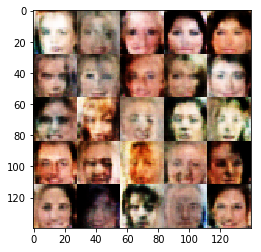

Epoch 1/1... batch: 1265 Discriminator Loss: 0.5531... Generator Loss: 3.0279
Epoch 1/1... batch: 1270 Discriminator Loss: 1.3856... Generator Loss: 0.5483
Epoch 1/1... batch: 1275 Discriminator Loss: 0.4337... Generator Loss: 3.8717
Epoch 1/1... batch: 1280 Discriminator Loss: 1.3922... Generator Loss: 0.5117
Epoch 1/1... batch: 1285 Discriminator Loss: 0.5710... Generator Loss: 5.0100
Epoch 1/1... batch: 1290 Discriminator Loss: 1.2677... Generator Loss: 0.6318
Epoch 1/1... batch: 1295 Discriminator Loss: 0.5654... Generator Loss: 4.1027
Epoch 1/1... batch: 1300 Discriminator Loss: 0.4907... Generator Loss: 6.0077
Epoch 1/1... batch: 1305 Discriminator Loss: 0.6654... Generator Loss: 1.8039
Epoch 1/1... batch: 1310 Discriminator Loss: 0.5012... Generator Loss: 5.5089
Epoch 1/1... batch: 1315 Discriminator Loss: 0.5806... Generator Loss: 2.3286
Epoch 1/1... batch: 1320 Discriminator Loss: 0.6994... Generator Loss: 1.4542


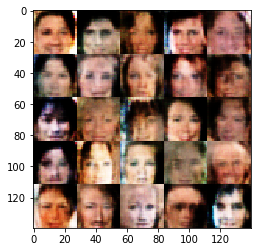

Epoch 1/1... batch: 1325 Discriminator Loss: 0.4344... Generator Loss: 5.7212
Epoch 1/1... batch: 1330 Discriminator Loss: 0.9129... Generator Loss: 6.0107
Epoch 1/1... batch: 1335 Discriminator Loss: 0.8435... Generator Loss: 1.0632
Epoch 1/1... batch: 1340 Discriminator Loss: 0.4606... Generator Loss: 4.4128
Epoch 1/1... batch: 1345 Discriminator Loss: 0.5622... Generator Loss: 2.3168
Epoch 1/1... batch: 1350 Discriminator Loss: 0.5604... Generator Loss: 2.0855
Epoch 1/1... batch: 1355 Discriminator Loss: 0.4736... Generator Loss: 6.7896
Epoch 1/1... batch: 1360 Discriminator Loss: 0.6514... Generator Loss: 2.2520
Epoch 1/1... batch: 1365 Discriminator Loss: 0.5556... Generator Loss: 2.2481
Epoch 1/1... batch: 1370 Discriminator Loss: 0.6289... Generator Loss: 8.8266
Epoch 1/1... batch: 1375 Discriminator Loss: 0.5876... Generator Loss: 1.9571
Epoch 1/1... batch: 1380 Discriminator Loss: 0.4598... Generator Loss: 6.3340


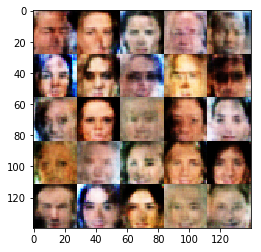

Epoch 1/1... batch: 1385 Discriminator Loss: 0.4669... Generator Loss: 6.0783
Epoch 1/1... batch: 1390 Discriminator Loss: 0.6779... Generator Loss: 6.9801
Epoch 1/1... batch: 1395 Discriminator Loss: 1.6911... Generator Loss: 0.4169
Epoch 1/1... batch: 1400 Discriminator Loss: 2.0002... Generator Loss: 0.3473
Epoch 1/1... batch: 1405 Discriminator Loss: 0.7727... Generator Loss: 1.3739
Epoch 1/1... batch: 1410 Discriminator Loss: 2.1051... Generator Loss: 0.2701
Epoch 1/1... batch: 1415 Discriminator Loss: 0.4980... Generator Loss: 4.2697
Epoch 1/1... batch: 1420 Discriminator Loss: 0.6622... Generator Loss: 1.7102
Epoch 1/1... batch: 1425 Discriminator Loss: 0.6541... Generator Loss: 1.8580
Epoch 1/1... batch: 1430 Discriminator Loss: 1.5195... Generator Loss: 0.5021
Epoch 1/1... batch: 1435 Discriminator Loss: 0.6133... Generator Loss: 2.3554
Epoch 1/1... batch: 1440 Discriminator Loss: 0.6895... Generator Loss: 1.5917


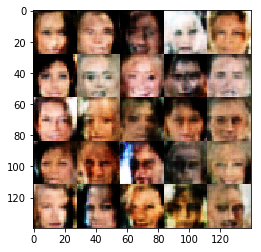

Epoch 1/1... batch: 1445 Discriminator Loss: 0.9067... Generator Loss: 0.9859
Epoch 1/1... batch: 1450 Discriminator Loss: 0.5603... Generator Loss: 3.5060
Epoch 1/1... batch: 1455 Discriminator Loss: 0.5617... Generator Loss: 2.3878
Epoch 1/1... batch: 1460 Discriminator Loss: 0.4660... Generator Loss: 3.6762
Epoch 1/1... batch: 1465 Discriminator Loss: 0.5225... Generator Loss: 3.5125
Epoch 1/1... batch: 1470 Discriminator Loss: 0.4442... Generator Loss: 3.5847
Epoch 1/1... batch: 1475 Discriminator Loss: 0.5368... Generator Loss: 2.2224
Epoch 1/1... batch: 1480 Discriminator Loss: 0.9629... Generator Loss: 5.7448
Epoch 1/1... batch: 1485 Discriminator Loss: 0.6334... Generator Loss: 1.7515
Epoch 1/1... batch: 1490 Discriminator Loss: 0.5362... Generator Loss: 4.3902
Epoch 1/1... batch: 1495 Discriminator Loss: 0.7821... Generator Loss: 1.2823
Epoch 1/1... batch: 1500 Discriminator Loss: 0.4829... Generator Loss: 4.1108


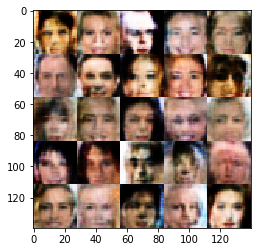

Epoch 1/1... batch: 1505 Discriminator Loss: 0.4752... Generator Loss: 5.3366
Epoch 1/1... batch: 1510 Discriminator Loss: 0.6807... Generator Loss: 1.7149
Epoch 1/1... batch: 1515 Discriminator Loss: 0.5003... Generator Loss: 2.7528
Epoch 1/1... batch: 1520 Discriminator Loss: 0.5536... Generator Loss: 2.8236
Epoch 1/1... batch: 1525 Discriminator Loss: 0.6880... Generator Loss: 5.5272
Epoch 1/1... batch: 1530 Discriminator Loss: 0.4639... Generator Loss: 4.4539
Epoch 1/1... batch: 1535 Discriminator Loss: 0.5338... Generator Loss: 2.0204
Epoch 1/1... batch: 1540 Discriminator Loss: 0.4027... Generator Loss: 4.5175
Epoch 1/1... batch: 1545 Discriminator Loss: 0.4589... Generator Loss: 4.6913
Epoch 1/1... batch: 1550 Discriminator Loss: 0.5920... Generator Loss: 1.9965
Epoch 1/1... batch: 1555 Discriminator Loss: 0.5624... Generator Loss: 2.3095
Epoch 1/1... batch: 1560 Discriminator Loss: 0.4211... Generator Loss: 5.4825


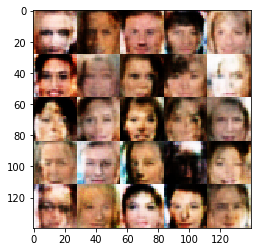

Epoch 1/1... batch: 1565 Discriminator Loss: 0.6423... Generator Loss: 1.7628
Epoch 1/1... batch: 1570 Discriminator Loss: 1.2168... Generator Loss: 4.3346
Epoch 1/1... batch: 1575 Discriminator Loss: 1.7562... Generator Loss: 2.2227
Epoch 1/1... batch: 1580 Discriminator Loss: 0.9776... Generator Loss: 1.9053
Epoch 1/1... batch: 1585 Discriminator Loss: 1.1807... Generator Loss: 1.8496
Epoch 1/1... batch: 1590 Discriminator Loss: 1.5337... Generator Loss: 3.8800
Epoch 1/1... batch: 1595 Discriminator Loss: 0.6577... Generator Loss: 3.2176
Epoch 1/1... batch: 1600 Discriminator Loss: 0.9407... Generator Loss: 2.9047
Epoch 1/1... batch: 1605 Discriminator Loss: 0.7435... Generator Loss: 1.3346
Epoch 1/1... batch: 1610 Discriminator Loss: 0.6458... Generator Loss: 3.1250
Epoch 1/1... batch: 1615 Discriminator Loss: 0.5046... Generator Loss: 3.6187
Epoch 1/1... batch: 1620 Discriminator Loss: 0.6957... Generator Loss: 1.6148


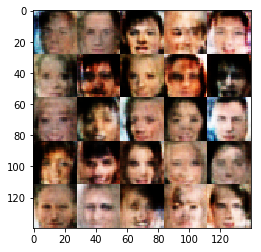

Epoch 1/1... batch: 1625 Discriminator Loss: 1.0289... Generator Loss: 0.8551
Epoch 1/1... batch: 1630 Discriminator Loss: 0.4619... Generator Loss: 5.2248
Epoch 1/1... batch: 1635 Discriminator Loss: 0.4928... Generator Loss: 2.7080
Epoch 1/1... batch: 1640 Discriminator Loss: 0.8244... Generator Loss: 1.1294
Epoch 1/1... batch: 1645 Discriminator Loss: 0.7144... Generator Loss: 5.6361
Epoch 1/1... batch: 1650 Discriminator Loss: 0.5953... Generator Loss: 2.0222
Epoch 1/1... batch: 1655 Discriminator Loss: 0.4649... Generator Loss: 4.9141
Epoch 1/1... batch: 1660 Discriminator Loss: 0.4780... Generator Loss: 3.0845
Epoch 1/1... batch: 1665 Discriminator Loss: 0.4378... Generator Loss: 4.5165
Epoch 1/1... batch: 1670 Discriminator Loss: 0.4819... Generator Loss: 2.8931
Epoch 1/1... batch: 1675 Discriminator Loss: 0.7065... Generator Loss: 3.4646
Epoch 1/1... batch: 1680 Discriminator Loss: 0.5055... Generator Loss: 3.0476


Epoch 1/1... batch: 1685 Discriminator Loss: 0.7958... Generator Loss: 5.5698
Epoch 1/1... batch: 1690 Discriminator Loss: 2.7865... Generator Loss: 3.6101
Epoch 1/1... batch: 1695 Discriminator Loss: 1.0266... Generator Loss: 1.0095
Epoch 1/1... batch: 1700 Discriminator Loss: 0.8015... Generator Loss: 2.0506
Epoch 1/1... batch: 1705 Discriminator Loss: 0.4945... Generator Loss: 2.8360
Epoch 1/1... batch: 1710 Discriminator Loss: 0.8271... Generator Loss: 5.4819
Epoch 1/1... batch: 1715 Discriminator Loss: 0.6820... Generator Loss: 1.7973
Epoch 1/1... batch: 1720 Discriminator Loss: 0.7034... Generator Loss: 1.5340
Epoch 1/1... batch: 1725 Discriminator Loss: 0.5450... Generator Loss: 4.3314
Epoch 1/1... batch: 1730 Discriminator Loss: 1.5388... Generator Loss: 0.4628
Epoch 1/1... batch: 1735 Discriminator Loss: 0.7804... Generator Loss: 1.2969
Epoch 1/1... batch: 1740 Discriminator Loss: 0.4981... Generator Loss: 3.4118


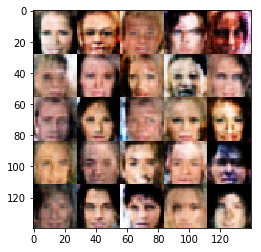

Epoch 1/1... batch: 1745 Discriminator Loss: 0.7751... Generator Loss: 1.2532
Epoch 1/1... batch: 1750 Discriminator Loss: 0.5467... Generator Loss: 3.6173
Epoch 1/1... batch: 1755 Discriminator Loss: 0.5116... Generator Loss: 2.6912
Epoch 1/1... batch: 1760 Discriminator Loss: 0.6338... Generator Loss: 5.1405
Epoch 1/1... batch: 1765 Discriminator Loss: 0.8468... Generator Loss: 1.1493
Epoch 1/1... batch: 1770 Discriminator Loss: 0.4947... Generator Loss: 5.3699
Epoch 1/1... batch: 1775 Discriminator Loss: 0.4140... Generator Loss: 4.0799
Epoch 1/1... batch: 1780 Discriminator Loss: 0.5105... Generator Loss: 3.0104
Epoch 1/1... batch: 1785 Discriminator Loss: 0.4730... Generator Loss: 6.8071
Epoch 1/1... batch: 1790 Discriminator Loss: 0.4322... Generator Loss: 3.8910
Epoch 1/1... batch: 1795 Discriminator Loss: 0.5004... Generator Loss: 4.9273
Epoch 1/1... batch: 1800 Discriminator Loss: 0.4068... Generator Loss: 4.7306


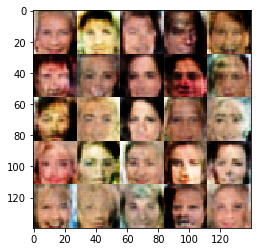

Epoch 1/1... batch: 1805 Discriminator Loss: 0.6693... Generator Loss: 7.3717
Epoch 1/1... batch: 1810 Discriminator Loss: 1.6611... Generator Loss: 3.7465
Epoch 1/1... batch: 1815 Discriminator Loss: 0.4951... Generator Loss: 3.7854
Epoch 1/1... batch: 1820 Discriminator Loss: 0.4263... Generator Loss: 4.7512
Epoch 1/1... batch: 1825 Discriminator Loss: 0.5314... Generator Loss: 2.6387
Epoch 1/1... batch: 1830 Discriminator Loss: 0.5002... Generator Loss: 3.0904
Epoch 1/1... batch: 1835 Discriminator Loss: 0.3791... Generator Loss: 5.7514
Epoch 1/1... batch: 1840 Discriminator Loss: 0.4668... Generator Loss: 6.6947
Epoch 1/1... batch: 1845 Discriminator Loss: 0.5308... Generator Loss: 2.7299
Epoch 1/1... batch: 1850 Discriminator Loss: 0.4620... Generator Loss: 4.7889
Epoch 1/1... batch: 1855 Discriminator Loss: 0.4385... Generator Loss: 5.6048
Epoch 1/1... batch: 1860 Discriminator Loss: 0.5224... Generator Loss: 2.1731


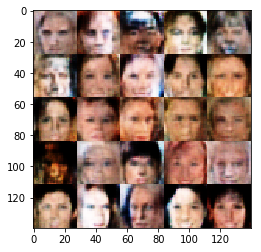

Epoch 1/1... batch: 1865 Discriminator Loss: 0.5666... Generator Loss: 2.4034
Epoch 1/1... batch: 1870 Discriminator Loss: 0.6588... Generator Loss: 5.0906
Epoch 1/1... batch: 1875 Discriminator Loss: 0.5017... Generator Loss: 4.7306
Epoch 1/1... batch: 1880 Discriminator Loss: 0.9038... Generator Loss: 5.7121
Epoch 1/1... batch: 1885 Discriminator Loss: 2.7332... Generator Loss: 4.5268
Epoch 1/1... batch: 1890 Discriminator Loss: 1.3474... Generator Loss: 0.6755
Epoch 1/1... batch: 1895 Discriminator Loss: 0.8934... Generator Loss: 1.5154
Epoch 1/1... batch: 1900 Discriminator Loss: 1.0404... Generator Loss: 1.1100
Epoch 1/1... batch: 1905 Discriminator Loss: 0.8713... Generator Loss: 1.3913
Epoch 1/1... batch: 1910 Discriminator Loss: 0.9338... Generator Loss: 0.9908
Epoch 1/1... batch: 1915 Discriminator Loss: 0.8502... Generator Loss: 1.8379
Epoch 1/1... batch: 1920 Discriminator Loss: 1.3804... Generator Loss: 0.5339


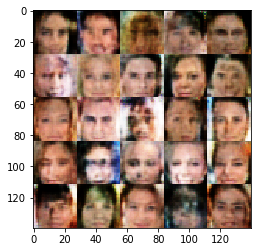

Epoch 1/1... batch: 1925 Discriminator Loss: 0.9043... Generator Loss: 1.1529
Epoch 1/1... batch: 1930 Discriminator Loss: 0.8828... Generator Loss: 1.2076
Epoch 1/1... batch: 1935 Discriminator Loss: 0.8327... Generator Loss: 1.5908
Epoch 1/1... batch: 1940 Discriminator Loss: 0.9370... Generator Loss: 1.1259
Epoch 1/1... batch: 1945 Discriminator Loss: 0.7403... Generator Loss: 1.7846
Epoch 1/1... batch: 1950 Discriminator Loss: 0.5460... Generator Loss: 2.3963
Epoch 1/1... batch: 1955 Discriminator Loss: 0.7037... Generator Loss: 1.7642
Epoch 1/1... batch: 1960 Discriminator Loss: 0.5067... Generator Loss: 3.9282
Epoch 1/1... batch: 1965 Discriminator Loss: 0.5066... Generator Loss: 3.1872
Epoch 1/1... batch: 1970 Discriminator Loss: 0.6950... Generator Loss: 1.6660
Epoch 1/1... batch: 1975 Discriminator Loss: 0.4785... Generator Loss: 3.2840
Epoch 1/1... batch: 1980 Discriminator Loss: 0.4815... Generator Loss: 4.9782


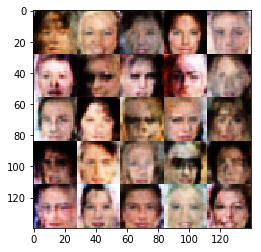

Epoch 1/1... batch: 1985 Discriminator Loss: 1.1662... Generator Loss: 0.6187
Epoch 1/1... batch: 1990 Discriminator Loss: 0.5515... Generator Loss: 2.4557
Epoch 1/1... batch: 1995 Discriminator Loss: 0.6246... Generator Loss: 1.7008
Epoch 1/1... batch: 2000 Discriminator Loss: 0.7404... Generator Loss: 1.4665
Epoch 1/1... batch: 2005 Discriminator Loss: 0.8231... Generator Loss: 3.5318
Epoch 1/1... batch: 2010 Discriminator Loss: 0.9190... Generator Loss: 6.5884
Epoch 1/1... batch: 2015 Discriminator Loss: 0.5540... Generator Loss: 4.1626
Epoch 1/1... batch: 2020 Discriminator Loss: 0.4466... Generator Loss: 5.8889
Epoch 1/1... batch: 2025 Discriminator Loss: 0.8449... Generator Loss: 5.1209
Epoch 1/1... batch: 2030 Discriminator Loss: 1.0437... Generator Loss: 5.4794
Epoch 1/1... batch: 2035 Discriminator Loss: 0.6031... Generator Loss: 2.0914
Epoch 1/1... batch: 2040 Discriminator Loss: 0.6758... Generator Loss: 2.2530


Epoch 1/1... batch: 2045 Discriminator Loss: 0.5060... Generator Loss: 3.1405
Epoch 1/1... batch: 2050 Discriminator Loss: 0.4366... Generator Loss: 5.0681
Epoch 1/1... batch: 2055 Discriminator Loss: 0.4297... Generator Loss: 4.5687
Epoch 1/1... batch: 2060 Discriminator Loss: 0.6751... Generator Loss: 1.6031
Epoch 1/1... batch: 2065 Discriminator Loss: 0.4939... Generator Loss: 2.7914
Epoch 1/1... batch: 2070 Discriminator Loss: 0.4588... Generator Loss: 5.3330
Epoch 1/1... batch: 2075 Discriminator Loss: 0.4858... Generator Loss: 3.3435
Epoch 1/1... batch: 2080 Discriminator Loss: 0.6165... Generator Loss: 1.8583
Epoch 1/1... batch: 2085 Discriminator Loss: 0.4696... Generator Loss: 5.5895
Epoch 1/1... batch: 2090 Discriminator Loss: 0.5615... Generator Loss: 2.3839
Epoch 1/1... batch: 2095 Discriminator Loss: 0.6245... Generator Loss: 1.8543
Epoch 1/1... batch: 2100 Discriminator Loss: 0.5262... Generator Loss: 3.2042


Epoch 1/1... batch: 2105 Discriminator Loss: 0.6196... Generator Loss: 1.9061
Epoch 1/1... batch: 2110 Discriminator Loss: 0.4878... Generator Loss: 5.9613
Epoch 1/1... batch: 2115 Discriminator Loss: 0.4887... Generator Loss: 4.2498
Epoch 1/1... batch: 2120 Discriminator Loss: 0.4249... Generator Loss: 5.2260
Epoch 1/1... batch: 2125 Discriminator Loss: 0.5049... Generator Loss: 2.6215
Epoch 1/1... batch: 2130 Discriminator Loss: 0.4730... Generator Loss: 2.3902
Epoch 1/1... batch: 2135 Discriminator Loss: 1.2072... Generator Loss: 5.7904
Epoch 1/1... batch: 2140 Discriminator Loss: 1.7264... Generator Loss: 2.3990
Epoch 1/1... batch: 2145 Discriminator Loss: 0.9260... Generator Loss: 1.3498
Epoch 1/1... batch: 2150 Discriminator Loss: 0.4856... Generator Loss: 2.8963
Epoch 1/1... batch: 2155 Discriminator Loss: 0.4719... Generator Loss: 3.1846
Epoch 1/1... batch: 2160 Discriminator Loss: 1.2939... Generator Loss: 0.6011


Epoch 1/1... batch: 2165 Discriminator Loss: 0.6474... Generator Loss: 3.4621
Epoch 1/1... batch: 2170 Discriminator Loss: 0.4749... Generator Loss: 4.7159
Epoch 1/1... batch: 2175 Discriminator Loss: 0.4740... Generator Loss: 2.5780
Epoch 1/1... batch: 2180 Discriminator Loss: 0.5189... Generator Loss: 2.2296
Epoch 1/1... batch: 2185 Discriminator Loss: 0.4660... Generator Loss: 5.4110
Epoch 1/1... batch: 2190 Discriminator Loss: 0.5756... Generator Loss: 1.9264
Epoch 1/1... batch: 2195 Discriminator Loss: 0.4911... Generator Loss: 3.1390
Epoch 1/1... batch: 2200 Discriminator Loss: 0.8064... Generator Loss: 1.2631
Epoch 1/1... batch: 2205 Discriminator Loss: 1.0823... Generator Loss: 2.4965
Epoch 1/1... batch: 2210 Discriminator Loss: 0.9153... Generator Loss: 1.0391
Epoch 1/1... batch: 2215 Discriminator Loss: 0.4813... Generator Loss: 4.3272
Epoch 1/1... batch: 2220 Discriminator Loss: 0.4550... Generator Loss: 4.1380


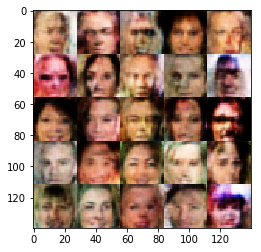

Epoch 1/1... batch: 2225 Discriminator Loss: 0.4332... Generator Loss: 5.5453
Epoch 1/1... batch: 2230 Discriminator Loss: 0.8362... Generator Loss: 1.1804
Epoch 1/1... batch: 2235 Discriminator Loss: 0.4886... Generator Loss: 2.9526
Epoch 1/1... batch: 2240 Discriminator Loss: 0.5020... Generator Loss: 2.8000
Epoch 1/1... batch: 2245 Discriminator Loss: 2.6587... Generator Loss: 0.1507
Epoch 1/1... batch: 2250 Discriminator Loss: 0.5528... Generator Loss: 2.7778
Epoch 1/1... batch: 2255 Discriminator Loss: 0.6724... Generator Loss: 1.4809
Epoch 1/1... batch: 2260 Discriminator Loss: 0.4461... Generator Loss: 3.3251
Epoch 1/1... batch: 2265 Discriminator Loss: 0.6122... Generator Loss: 1.9313
Epoch 1/1... batch: 2270 Discriminator Loss: 0.4404... Generator Loss: 5.1299
Epoch 1/1... batch: 2275 Discriminator Loss: 0.4927... Generator Loss: 3.0427
Epoch 1/1... batch: 2280 Discriminator Loss: 0.4590... Generator Loss: 5.8708


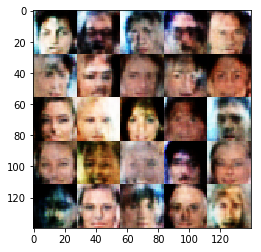

Epoch 1/1... batch: 2285 Discriminator Loss: 0.4878... Generator Loss: 4.0637
Epoch 1/1... batch: 2290 Discriminator Loss: 0.4749... Generator Loss: 5.5670
Epoch 1/1... batch: 2295 Discriminator Loss: 0.4837... Generator Loss: 2.8663
Epoch 1/1... batch: 2300 Discriminator Loss: 0.4090... Generator Loss: 4.0404
Epoch 1/1... batch: 2305 Discriminator Loss: 0.4975... Generator Loss: 5.7167
Epoch 1/1... batch: 2310 Discriminator Loss: 0.4619... Generator Loss: 3.8088
Epoch 1/1... batch: 2315 Discriminator Loss: 0.6381... Generator Loss: 1.7707
Epoch 1/1... batch: 2320 Discriminator Loss: 0.5261... Generator Loss: 5.5289
Epoch 1/1... batch: 2325 Discriminator Loss: 2.9287... Generator Loss: 0.1676
Epoch 1/1... batch: 2330 Discriminator Loss: 0.8151... Generator Loss: 1.5687
Epoch 1/1... batch: 2335 Discriminator Loss: 0.8630... Generator Loss: 1.3501
Epoch 1/1... batch: 2340 Discriminator Loss: 0.6221... Generator Loss: 2.9208


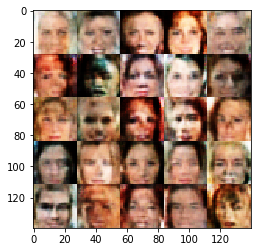

Epoch 1/1... batch: 2345 Discriminator Loss: 0.5329... Generator Loss: 3.2659
Epoch 1/1... batch: 2350 Discriminator Loss: 0.5243... Generator Loss: 5.0344
Epoch 1/1... batch: 2355 Discriminator Loss: 1.1178... Generator Loss: 0.7866
Epoch 1/1... batch: 2360 Discriminator Loss: 0.4651... Generator Loss: 2.9343
Epoch 1/1... batch: 2365 Discriminator Loss: 0.6416... Generator Loss: 5.3880
Epoch 1/1... batch: 2370 Discriminator Loss: 0.9992... Generator Loss: 0.9741
Epoch 1/1... batch: 2375 Discriminator Loss: 1.9764... Generator Loss: 0.3748
Epoch 1/1... batch: 2380 Discriminator Loss: 0.5876... Generator Loss: 2.1545
Epoch 1/1... batch: 2385 Discriminator Loss: 0.4404... Generator Loss: 5.0357
Epoch 1/1... batch: 2390 Discriminator Loss: 0.5591... Generator Loss: 2.0352
Epoch 1/1... batch: 2395 Discriminator Loss: 0.5204... Generator Loss: 2.2979
Epoch 1/1... batch: 2400 Discriminator Loss: 0.4588... Generator Loss: 4.4105


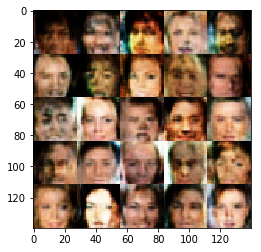

Epoch 1/1... batch: 2405 Discriminator Loss: 0.6021... Generator Loss: 3.2862
Epoch 1/1... batch: 2410 Discriminator Loss: 0.4356... Generator Loss: 4.1294
Epoch 1/1... batch: 2415 Discriminator Loss: 0.4450... Generator Loss: 4.0917
Epoch 1/1... batch: 2420 Discriminator Loss: 0.4725... Generator Loss: 7.2068
Epoch 1/1... batch: 2425 Discriminator Loss: 0.4845... Generator Loss: 3.5777
Epoch 1/1... batch: 2430 Discriminator Loss: 0.6280... Generator Loss: 1.8904
Epoch 1/1... batch: 2435 Discriminator Loss: 0.5858... Generator Loss: 2.1167
Epoch 1/1... batch: 2440 Discriminator Loss: 0.6845... Generator Loss: 4.2649
Epoch 1/1... batch: 2445 Discriminator Loss: 0.4276... Generator Loss: 3.8771
Epoch 1/1... batch: 2450 Discriminator Loss: 0.5205... Generator Loss: 5.1282
Epoch 1/1... batch: 2455 Discriminator Loss: 0.6469... Generator Loss: 5.1382
Epoch 1/1... batch: 2460 Discriminator Loss: 1.4444... Generator Loss: 0.5619


Epoch 1/1... batch: 2465 Discriminator Loss: 1.1785... Generator Loss: 0.7180
Epoch 1/1... batch: 2470 Discriminator Loss: 0.6639... Generator Loss: 1.6769
Epoch 1/1... batch: 2475 Discriminator Loss: 0.6811... Generator Loss: 1.5065
Epoch 1/1... batch: 2480 Discriminator Loss: 0.7635... Generator Loss: 1.2791
Epoch 1/1... batch: 2485 Discriminator Loss: 1.5446... Generator Loss: 0.4848
Epoch 1/1... batch: 2490 Discriminator Loss: 0.6179... Generator Loss: 3.6509
Epoch 1/1... batch: 2495 Discriminator Loss: 0.6247... Generator Loss: 2.3766
Epoch 1/1... batch: 2500 Discriminator Loss: 0.4807... Generator Loss: 4.4576
Epoch 1/1... batch: 2505 Discriminator Loss: 0.7217... Generator Loss: 1.3539
Epoch 1/1... batch: 2510 Discriminator Loss: 0.6250... Generator Loss: 2.0328
Epoch 1/1... batch: 2515 Discriminator Loss: 0.6163... Generator Loss: 4.2170
Epoch 1/1... batch: 2520 Discriminator Loss: 0.5577... Generator Loss: 2.8628


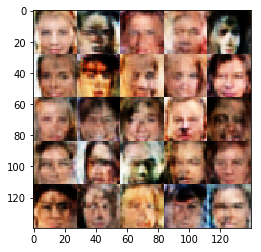

Epoch 1/1... batch: 2525 Discriminator Loss: 1.3128... Generator Loss: 4.0089
Epoch 1/1... batch: 2530 Discriminator Loss: 0.7348... Generator Loss: 1.5857
Epoch 1/1... batch: 2535 Discriminator Loss: 0.6005... Generator Loss: 2.1696
Epoch 1/1... batch: 2540 Discriminator Loss: 0.4639... Generator Loss: 4.6061
Epoch 1/1... batch: 2545 Discriminator Loss: 0.9630... Generator Loss: 3.5062
Epoch 1/1... batch: 2550 Discriminator Loss: 0.8122... Generator Loss: 1.5244
Epoch 1/1... batch: 2555 Discriminator Loss: 1.0275... Generator Loss: 1.9701
Epoch 1/1... batch: 2560 Discriminator Loss: 2.2332... Generator Loss: 0.3009
Epoch 1/1... batch: 2565 Discriminator Loss: 0.6702... Generator Loss: 1.9767
Epoch 1/1... batch: 2570 Discriminator Loss: 0.5020... Generator Loss: 3.5383
Epoch 1/1... batch: 2575 Discriminator Loss: 1.7753... Generator Loss: 0.3653
Epoch 1/1... batch: 2580 Discriminator Loss: 0.6634... Generator Loss: 1.6816


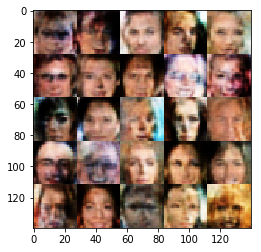

Epoch 1/1... batch: 2585 Discriminator Loss: 0.4577... Generator Loss: 3.3453
Epoch 1/1... batch: 2590 Discriminator Loss: 0.4778... Generator Loss: 4.8840
Epoch 1/1... batch: 2595 Discriminator Loss: 0.4331... Generator Loss: 3.4272
Epoch 1/1... batch: 2600 Discriminator Loss: 0.7017... Generator Loss: 1.4543
Epoch 1/1... batch: 2605 Discriminator Loss: 0.4789... Generator Loss: 3.1652
Epoch 1/1... batch: 2610 Discriminator Loss: 0.9131... Generator Loss: 4.5742
Epoch 1/1... batch: 2615 Discriminator Loss: 0.4421... Generator Loss: 5.6078
Epoch 1/1... batch: 2620 Discriminator Loss: 0.4717... Generator Loss: 3.5283
Epoch 1/1... batch: 2625 Discriminator Loss: 0.4539... Generator Loss: 2.5741
Epoch 1/1... batch: 2630 Discriminator Loss: 0.4385... Generator Loss: 2.9088
Epoch 1/1... batch: 2635 Discriminator Loss: 0.5290... Generator Loss: 2.5588
Epoch 1/1... batch: 2640 Discriminator Loss: 0.5844... Generator Loss: 2.2985


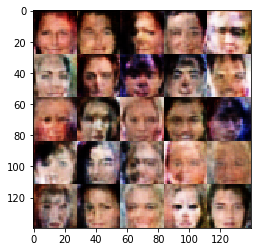

Epoch 1/1... batch: 2645 Discriminator Loss: 0.5731... Generator Loss: 2.1122
Epoch 1/1... batch: 2650 Discriminator Loss: 0.5037... Generator Loss: 2.5859
Epoch 1/1... batch: 2655 Discriminator Loss: 0.5265... Generator Loss: 3.0217
Epoch 1/1... batch: 2660 Discriminator Loss: 0.6550... Generator Loss: 1.8015
Epoch 1/1... batch: 2665 Discriminator Loss: 0.4504... Generator Loss: 4.5196
Epoch 1/1... batch: 2670 Discriminator Loss: 0.5379... Generator Loss: 2.5086
Epoch 1/1... batch: 2675 Discriminator Loss: 2.0481... Generator Loss: 0.3342
Epoch 1/1... batch: 2680 Discriminator Loss: 0.9327... Generator Loss: 1.0907
Epoch 1/1... batch: 2685 Discriminator Loss: 1.4718... Generator Loss: 2.3168
Epoch 1/1... batch: 2690 Discriminator Loss: 0.8392... Generator Loss: 1.6469
Epoch 1/1... batch: 2695 Discriminator Loss: 0.8953... Generator Loss: 1.2690
Epoch 1/1... batch: 2700 Discriminator Loss: 0.6054... Generator Loss: 2.0452


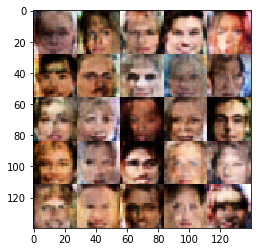

Epoch 1/1... batch: 2705 Discriminator Loss: 0.5995... Generator Loss: 2.2181
Epoch 1/1... batch: 2710 Discriminator Loss: 0.5318... Generator Loss: 4.6476
Epoch 1/1... batch: 2715 Discriminator Loss: 0.7011... Generator Loss: 1.5846
Epoch 1/1... batch: 2720 Discriminator Loss: 0.6456... Generator Loss: 1.9467
Epoch 1/1... batch: 2725 Discriminator Loss: 0.4666... Generator Loss: 3.7204
Epoch 1/1... batch: 2730 Discriminator Loss: 0.9913... Generator Loss: 0.9962
Epoch 1/1... batch: 2735 Discriminator Loss: 0.7086... Generator Loss: 1.5214
Epoch 1/1... batch: 2740 Discriminator Loss: 0.4593... Generator Loss: 3.9102
Epoch 1/1... batch: 2745 Discriminator Loss: 0.4682... Generator Loss: 4.3199
Epoch 1/1... batch: 2750 Discriminator Loss: 0.4961... Generator Loss: 3.0897
Epoch 1/1... batch: 2755 Discriminator Loss: 0.4197... Generator Loss: 6.2517
Epoch 1/1... batch: 2760 Discriminator Loss: 0.4919... Generator Loss: 3.1881


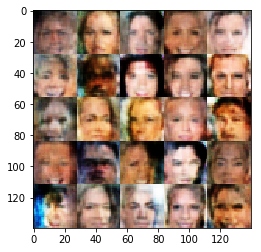

Epoch 1/1... batch: 2765 Discriminator Loss: 0.4523... Generator Loss: 6.1519
Epoch 1/1... batch: 2770 Discriminator Loss: 0.4568... Generator Loss: 5.1859
Epoch 1/1... batch: 2775 Discriminator Loss: 0.4258... Generator Loss: 6.9051
Epoch 1/1... batch: 2780 Discriminator Loss: 0.5120... Generator Loss: 2.7022
Epoch 1/1... batch: 2785 Discriminator Loss: 0.5024... Generator Loss: 3.1169
Epoch 1/1... batch: 2790 Discriminator Loss: 0.4858... Generator Loss: 3.2496
Epoch 1/1... batch: 2795 Discriminator Loss: 0.9519... Generator Loss: 2.7217
Epoch 1/1... batch: 2800 Discriminator Loss: 0.4784... Generator Loss: 4.1662
Epoch 1/1... batch: 2805 Discriminator Loss: 0.6639... Generator Loss: 1.7707
Epoch 1/1... batch: 2810 Discriminator Loss: 0.5080... Generator Loss: 3.0422
Epoch 1/1... batch: 2815 Discriminator Loss: 1.0154... Generator Loss: 0.8955
Epoch 1/1... batch: 2820 Discriminator Loss: 0.4660... Generator Loss: 4.0752


Epoch 1/1... batch: 2825 Discriminator Loss: 0.4483... Generator Loss: 3.0393
Epoch 1/1... batch: 2830 Discriminator Loss: 0.6243... Generator Loss: 1.6577
Epoch 1/1... batch: 2835 Discriminator Loss: 0.4441... Generator Loss: 4.2743
Epoch 1/1... batch: 2840 Discriminator Loss: 0.5519... Generator Loss: 1.9227
Epoch 1/1... batch: 2845 Discriminator Loss: 0.6481... Generator Loss: 1.5925
Epoch 1/1... batch: 2850 Discriminator Loss: 0.5616... Generator Loss: 2.4423
Epoch 1/1... batch: 2855 Discriminator Loss: 0.7998... Generator Loss: 6.0160
Epoch 1/1... batch: 2860 Discriminator Loss: 0.4321... Generator Loss: 4.4943
Epoch 1/1... batch: 2865 Discriminator Loss: 0.4902... Generator Loss: 3.8164
Epoch 1/1... batch: 2870 Discriminator Loss: 0.4741... Generator Loss: 3.7162
Epoch 1/1... batch: 2875 Discriminator Loss: 0.7154... Generator Loss: 1.4109
Epoch 1/1... batch: 2880 Discriminator Loss: 0.4133... Generator Loss: 5.2882


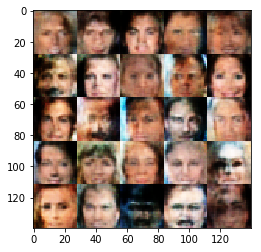

Epoch 1/1... batch: 2885 Discriminator Loss: 0.5672... Generator Loss: 1.8435
Epoch 1/1... batch: 2890 Discriminator Loss: 0.5210... Generator Loss: 2.8099
Epoch 1/1... batch: 2895 Discriminator Loss: 0.5356... Generator Loss: 7.5779
Epoch 1/1... batch: 2900 Discriminator Loss: 0.4597... Generator Loss: 6.1146
Epoch 1/1... batch: 2905 Discriminator Loss: 0.5182... Generator Loss: 2.1253
Epoch 1/1... batch: 2910 Discriminator Loss: 0.5301... Generator Loss: 2.3638
Epoch 1/1... batch: 2915 Discriminator Loss: 0.4909... Generator Loss: 4.5401
Epoch 1/1... batch: 2920 Discriminator Loss: 0.4879... Generator Loss: 7.5171
Epoch 1/1... batch: 2925 Discriminator Loss: 0.9578... Generator Loss: 3.5055
Epoch 1/1... batch: 2930 Discriminator Loss: 0.9113... Generator Loss: 1.1301
Epoch 1/1... batch: 2935 Discriminator Loss: 0.5134... Generator Loss: 3.1193
Epoch 1/1... batch: 2940 Discriminator Loss: 0.6629... Generator Loss: 1.8451


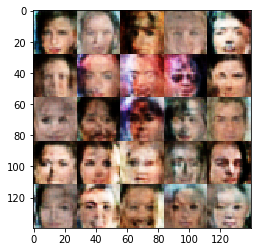

Epoch 1/1... batch: 2945 Discriminator Loss: 0.8849... Generator Loss: 1.0421
Epoch 1/1... batch: 2950 Discriminator Loss: 1.3778... Generator Loss: 2.8471
Epoch 1/1... batch: 2955 Discriminator Loss: 1.3190... Generator Loss: 0.6543
Epoch 1/1... batch: 2960 Discriminator Loss: 0.4940... Generator Loss: 2.7828
Epoch 1/1... batch: 2965 Discriminator Loss: 0.5073... Generator Loss: 2.4018
Epoch 1/1... batch: 2970 Discriminator Loss: 0.4931... Generator Loss: 3.9735
Epoch 1/1... batch: 2975 Discriminator Loss: 1.0468... Generator Loss: 0.7943
Epoch 1/1... batch: 2980 Discriminator Loss: 0.7788... Generator Loss: 1.3021
Epoch 1/1... batch: 2985 Discriminator Loss: 0.4969... Generator Loss: 2.5930
Epoch 1/1... batch: 2990 Discriminator Loss: 0.7639... Generator Loss: 1.2874
Epoch 1/1... batch: 2995 Discriminator Loss: 0.5638... Generator Loss: 3.4646
Epoch 1/1... batch: 3000 Discriminator Loss: 0.5095... Generator Loss: 4.6760


Epoch 1/1... batch: 3005 Discriminator Loss: 1.1760... Generator Loss: 3.4716
Epoch 1/1... batch: 3010 Discriminator Loss: 1.9675... Generator Loss: 0.3412
Epoch 1/1... batch: 3015 Discriminator Loss: 1.9983... Generator Loss: 2.7391
Epoch 1/1... batch: 3020 Discriminator Loss: 0.8516... Generator Loss: 1.6883
Epoch 1/1... batch: 3025 Discriminator Loss: 1.0945... Generator Loss: 0.8359
Epoch 1/1... batch: 3030 Discriminator Loss: 1.1517... Generator Loss: 3.1532
Epoch 1/1... batch: 3035 Discriminator Loss: 0.5367... Generator Loss: 3.0509
Epoch 1/1... batch: 3040 Discriminator Loss: 0.6334... Generator Loss: 5.5664
Epoch 1/1... batch: 3045 Discriminator Loss: 0.4933... Generator Loss: 3.6658
Epoch 1/1... batch: 3050 Discriminator Loss: 0.9855... Generator Loss: 0.9420
Epoch 1/1... batch: 3055 Discriminator Loss: 0.6445... Generator Loss: 2.2386
Epoch 1/1... batch: 3060 Discriminator Loss: 0.4144... Generator Loss: 4.4500


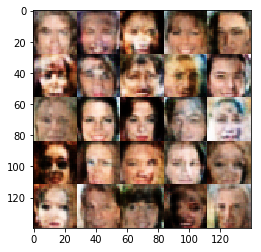

Epoch 1/1... batch: 3065 Discriminator Loss: 0.7332... Generator Loss: 1.6965
Epoch 1/1... batch: 3070 Discriminator Loss: 0.4859... Generator Loss: 2.7665
Epoch 1/1... batch: 3075 Discriminator Loss: 0.6911... Generator Loss: 2.7079
Epoch 1/1... batch: 3080 Discriminator Loss: 0.7096... Generator Loss: 3.2109
Epoch 1/1... batch: 3085 Discriminator Loss: 0.7921... Generator Loss: 3.5954
Epoch 1/1... batch: 3090 Discriminator Loss: 0.6199... Generator Loss: 2.3619
Epoch 1/1... batch: 3095 Discriminator Loss: 0.5049... Generator Loss: 3.4504
Epoch 1/1... batch: 3100 Discriminator Loss: 0.6237... Generator Loss: 3.1840
Epoch 1/1... batch: 3105 Discriminator Loss: 0.6612... Generator Loss: 1.9859
Epoch 1/1... batch: 3110 Discriminator Loss: 0.5188... Generator Loss: 2.3615
Epoch 1/1... batch: 3115 Discriminator Loss: 0.5777... Generator Loss: 2.0826
Epoch 1/1... batch: 3120 Discriminator Loss: 0.5203... Generator Loss: 3.6200


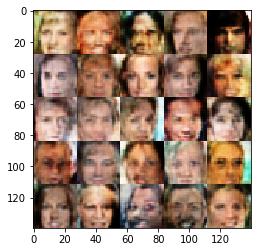

Epoch 1/1... batch: 3125 Discriminator Loss: 0.5304... Generator Loss: 2.4521
Epoch 1/1... batch: 3130 Discriminator Loss: 0.5327... Generator Loss: 4.7686
Epoch 1/1... batch: 3135 Discriminator Loss: 0.6581... Generator Loss: 4.1729
Epoch 1/1... batch: 3140 Discriminator Loss: 0.5509... Generator Loss: 4.5345
Epoch 1/1... batch: 3145 Discriminator Loss: 0.6304... Generator Loss: 2.0998
Epoch 1/1... batch: 3150 Discriminator Loss: 0.4579... Generator Loss: 2.8167
Epoch 1/1... batch: 3155 Discriminator Loss: 0.4873... Generator Loss: 3.4499
Epoch 1/1... batch: 3160 Discriminator Loss: 0.4968... Generator Loss: 3.5691
Epoch 1/1... batch: 3165 Discriminator Loss: 0.6573... Generator Loss: 1.7180


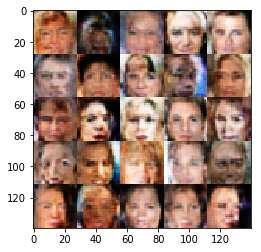

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.